In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('ignore')

# package
import datetime as datetime

In [2]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=0)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

filepath = "./data"

def read_files(file_name,chunk_size):
    path = os.getcwd()
    path = os.path.join(path, "data/{}.csv").format(file_name)
    TextFileReader = pd.read_csv(path, chunksize=chunk_size,encoding='cp949')
    dfList = []
    for df in TextFileReader:
        dfList.append(df)

    df = pd.concat(dfList,sort=False)
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [3]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import pickle
import datetime

In [4]:
log_data1 = read_file('data/log_merge1.csv')
log_data2 = read_file('data/log_merge2.csv')
doll_info = read_file('data/merge_v5.csv')

log_data1 = log_data1[log_data1.doll_id.isin(doll_info.doll_id.unique())].reset_index(drop = True)
log_data2 = log_data2[log_data2.doll_id.isin(doll_info.doll_id.unique())].reset_index(drop = True)

log_data1.shape, log_data2.shape

...There are no duplicates
shape: (927578, 15)
...There are no duplicates
shape: (632531, 24)
...There are no duplicates
shape: (3182, 46)


((521214, 15), (414600, 24))

In [5]:
change_list1 = ['stroke', 'hand_hold', 'knock', 'gymnastics', 'brain_timer']
change_list2 = ['stroke', 'hand_hold', 'knock', 'gymnastics_x', 'brain_timer', 
                'story', 'religion', 'music', 'english', 'rememberance', 'quiz', 'gymnastics_y']

for i in change_list1:
    log_data1[i][log_data1[i]<0] = 0
for j in change_list2:
    log_data2[j][log_data2[j]<0] = 0

In [6]:
# 사용 시작 날짜
start_date = log_data1.groupby('doll_id').min()['date']

# 귀 기능 이후에 처음 시작한 유저들
after_ear_users = start_date[start_date > '2020-04-21'].index.values

# 귀 기능 이후에 처음 등장한 유저들만을 기준으로 만든 dataframe
afear_log = log_data2[log_data2['doll_id'].isin(after_ear_users)]

afear_log.doll_id.nunique()

2358

In [7]:
afear_log = afear_log.reset_index(drop = True)

In [8]:
#사용일수 column 생성
afear_log['doll_s'] = 1
afear_log['use_days'] = afear_log.groupby('doll_id').cumsum()['doll_s']

In [9]:
max_use_days = afear_log.groupby('doll_id').max()['use_days']
max_use_days.describe()

count   2,358.0000
mean      103.8185
std       107.0381
min         1.0000
25%         8.0000
50%        58.0000
75%       192.0000
max       385.0000
Name: use_days, dtype: float64

In [10]:
use_id = max_use_days[max_use_days>=14].index

In [11]:
df = afear_log[afear_log.doll_id.isin(use_id)].reset_index(drop=True)

df = df[df.use_days<=70]

df.doll_id.nunique()

1681

In [12]:
for i in change_list2: 
    df[f'{i}_yn'] =0
    
for i in change_list2: 
    df.loc[df[i]!=0, f'{i}_yn']=1
    
logdic = []
for i in change_list2:
    logdic.append(f'{i}_yn')

In [13]:
df_filter = deepcopy(df)
df_filter = df_filter[['doll_id']+logdic]
df_filter = df_filter.groupby(['doll_id']).sum().reset_index()

In [14]:
df_filter.head()

,doll_id,stroke_yn,hand_hold_yn,knock_yn,gymnastics_x_yn,brain_timer_yn,story_yn,religion_yn,music_yn,english_yn,rememberance_yn,quiz_yn,gymnastics_y_yn
0,128038,8,10,34,4,5,0,0,0,0,0,0,0
1,128039,17,7,6,8,4,0,0,0,0,0,0,0
2,128040,15,23,33,5,8,0,0,0,0,0,0,0
3,128041,59,30,59,10,5,0,0,0,0,0,0,0
4,128042,1,15,0,0,3,0,0,0,0,0,0,0


In [15]:
ear_list = ['story_yn', 'religion_yn', 'music_yn', 'english_yn',
       'rememberance_yn', 'quiz_yn', 'gymnastics_y_yn']

In [16]:
df_filter['earf']=df_filter[ear_list].sum(axis=1)

In [17]:
use_id2 = df_filter[df_filter.earf!=0].doll_id.unique()

In [18]:
len(use_id2)

1431

In [19]:
for i in logdic: 
    print(i, len(df_filter[(df_filter.doll_id.isin(use_id))&(df_filter[i]==0)]), sep = " : ")

stroke_yn : 85
hand_hold_yn : 60
knock_yn : 118
gymnastics_x_yn : 358
brain_timer_yn : 538
story_yn : 849
religion_yn : 973
music_yn : 432
english_yn : 1232
rememberance_yn : 922
quiz_yn : 710
gymnastics_y_yn : 533


# 예측할 컬럼

In [20]:
predict_col = ['stroke', 'hand_hold', 'knock', 'quiz', 'music', 'gymnastics_y']

In [21]:
df = df[df.doll_id.isin(use_id2)].reset_index(drop=True)

In [22]:
df['use_week'] = np.nan

In [23]:
for i in range(1, 11): 
    df.loc[(df['use_days']>7*(i-1))&(df['use_days']<=7*(i)), 'use_week'] = i

In [24]:
# df['use_week'] = df.use_week.astype('int').astype('str')+'_w'

In [25]:
df_reg = df.groupby(['doll_id', 'use_week']).sum().reset_index()

In [26]:
Xcol = ['stroke', 'hand_hold', 'knock',
        'consume_cnt','story', 'religion', 'music', 'english','rememberance', 'quiz', 'gymnastics_y']

In [27]:
df_reg = df_reg[['doll_id', 'use_week']+Xcol]

In [28]:
df_reg.index = df_reg.doll_id

In [29]:
df_reg.head(3)

,doll_id,use_week,stroke,hand_hold,knock,consume_cnt,story,religion,music,english,rememberance,quiz,gymnastics_y
doll_id,,,,,,,,,,,,,
128060,128060,1.0000,2.0000,7.0000,3.0000,0.0000,0.0000,2.0000,6.0000,0.0000,1.0000,0.0000,0.0000
128060,128060,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
128060,128060,3.0000,3.0000,4.0000,2.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000


## t주의 모델은 t-1의 로그 데이터를 X 값으로 사용함

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor

## pycaret을 통해 HuberRegressor, RandomForest가 좋은 걸 확인

In [31]:
res = pd.DataFrame(index = predict_col, columns = [2,3,4,5,6,7,8,9,10])

res

,2,3,4,5,6,7,8,9,10
stroke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hand_hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
knock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quiz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gymnastics_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


stroke : 1431명 : 53.80265990313932


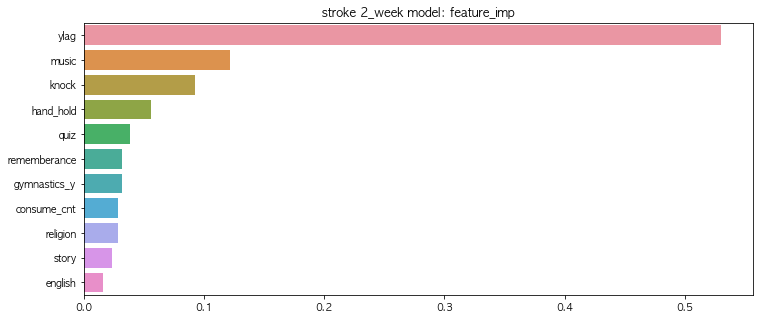

stroke : 1420명 : 35.150964832765986


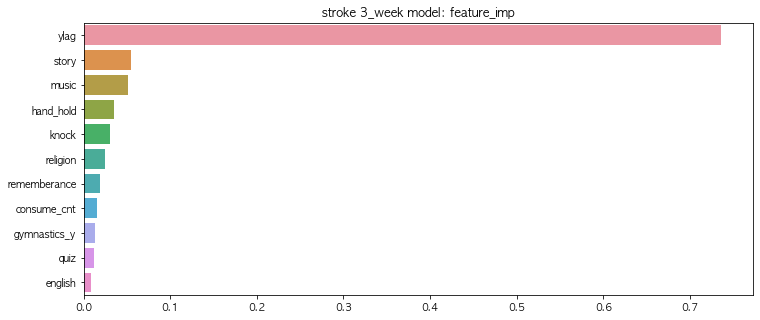

stroke : 1297명 : 24.19959175919111


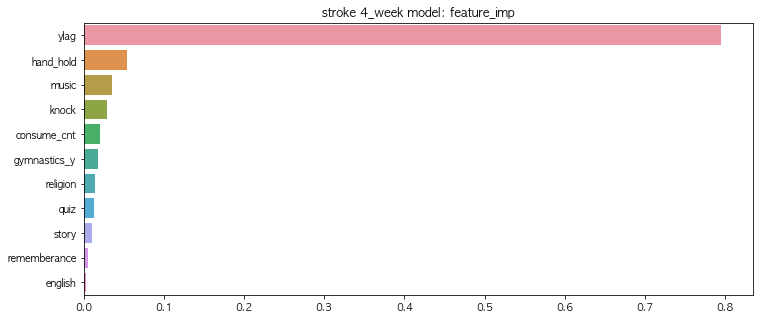

stroke : 1246명 : 28.68232297727669


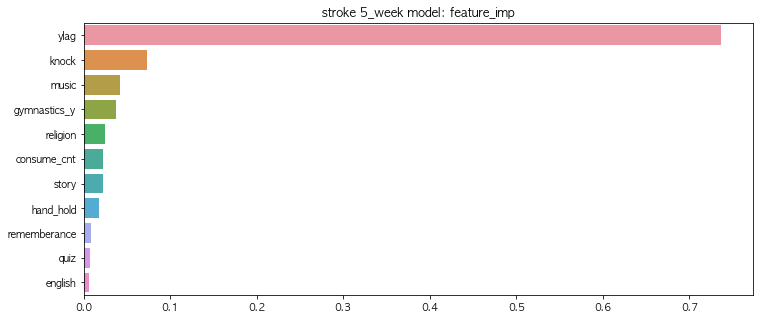

stroke : 1210명 : 31.48703211808395


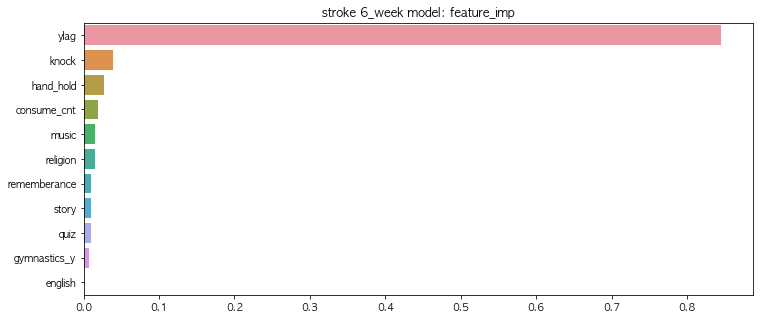

stroke : 1152명 : 18.50686267910017


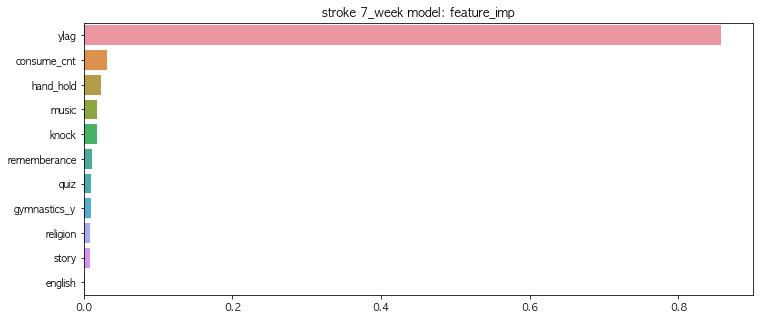

stroke : 1106명 : 18.67193212570542


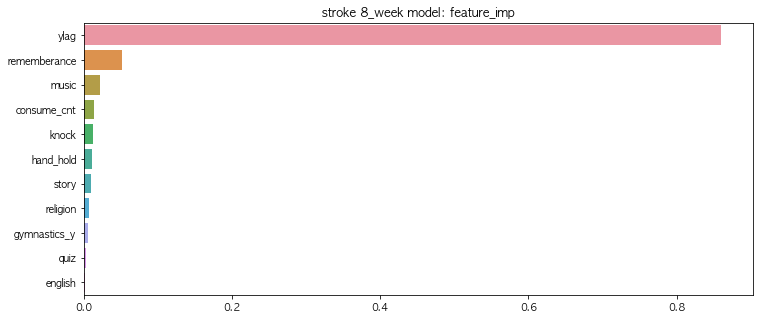

stroke : 1038명 : 16.194500660986275


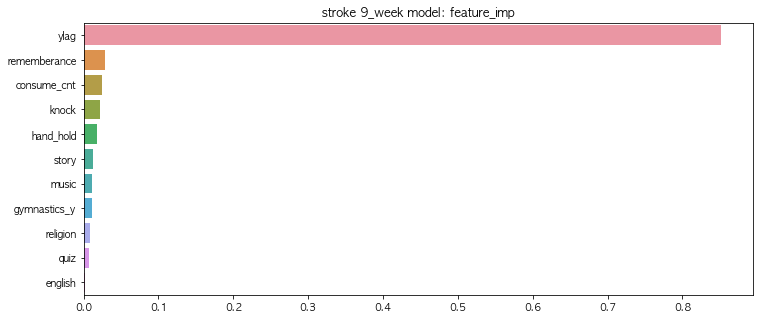

stroke : 954명 : 14.140650074094102


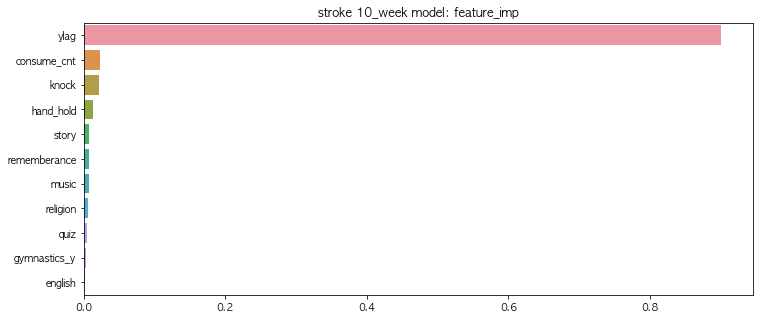

hand_hold : 1431명 : 88.46250408469174


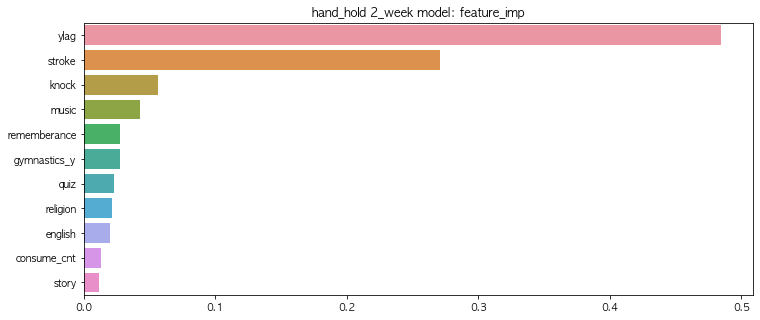

hand_hold : 1420명 : 49.91993497410676


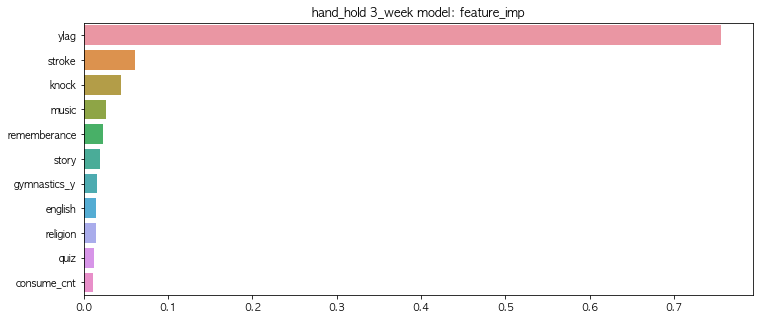

hand_hold : 1297명 : 53.310769023308914


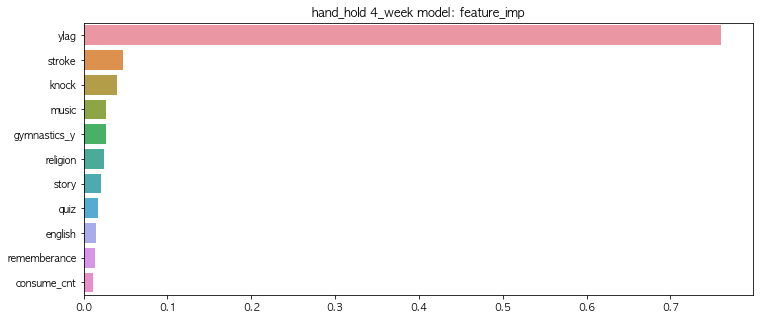

hand_hold : 1246명 : 34.623132192192735


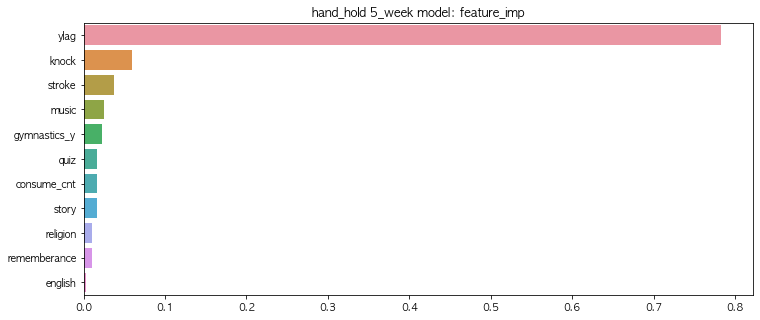

hand_hold : 1210명 : 41.30967534453892


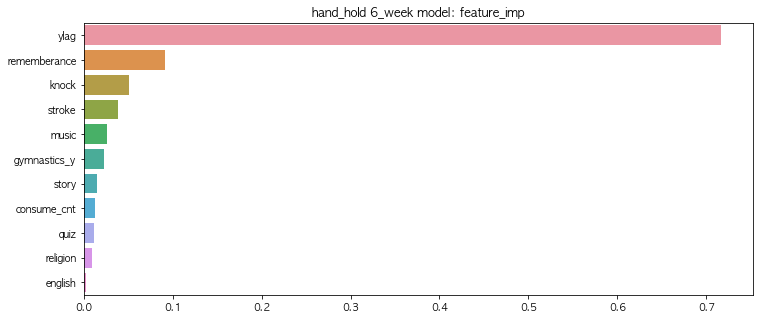

hand_hold : 1152명 : 27.98356559334203


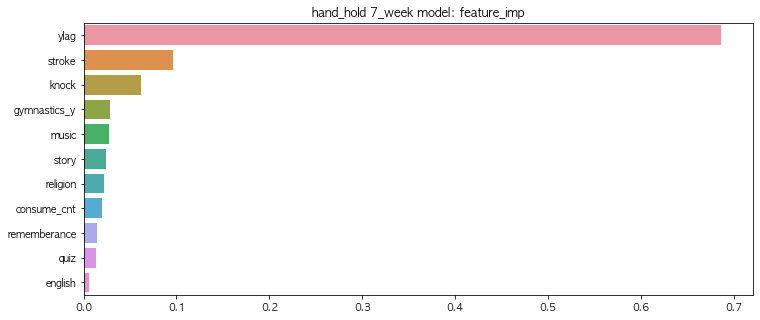

hand_hold : 1106명 : 25.473081050920907


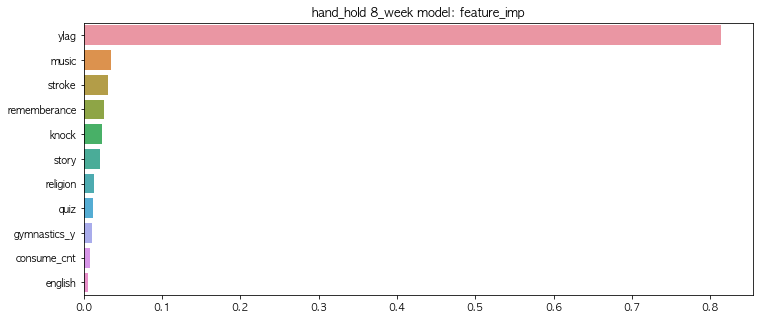

hand_hold : 1038명 : 21.9436649508831


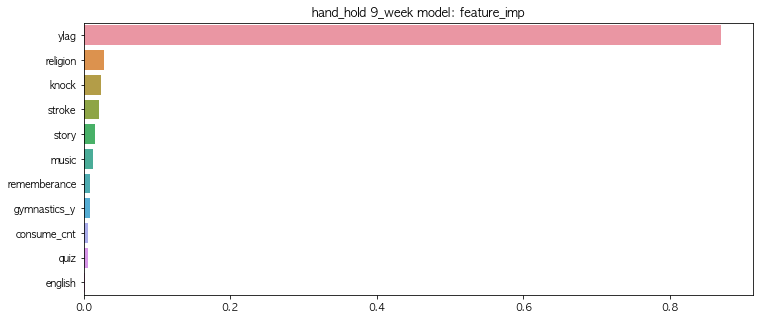

hand_hold : 954명 : 31.194643088867778


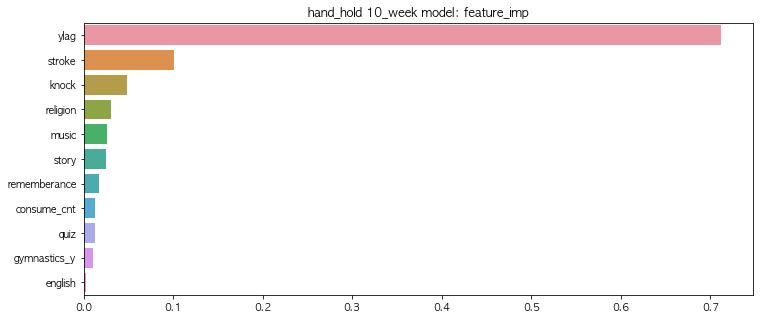

knock : 1431명 : 60.67796566601845


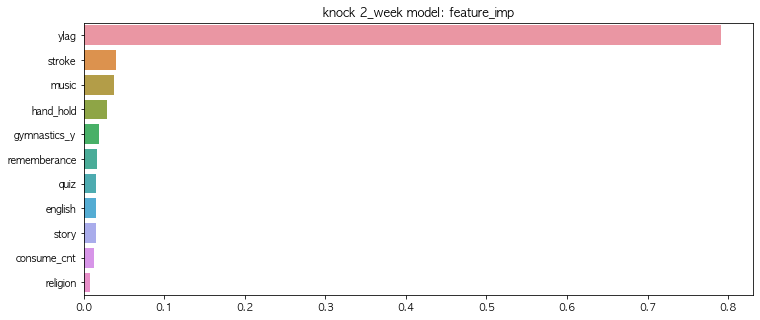

knock : 1420명 : 46.71934766590628


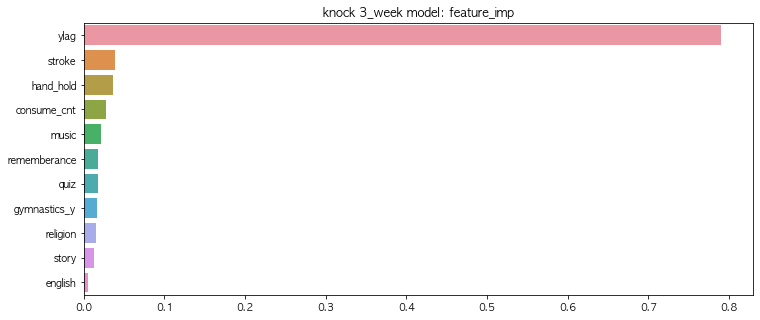

knock : 1297명 : 42.43455386003334


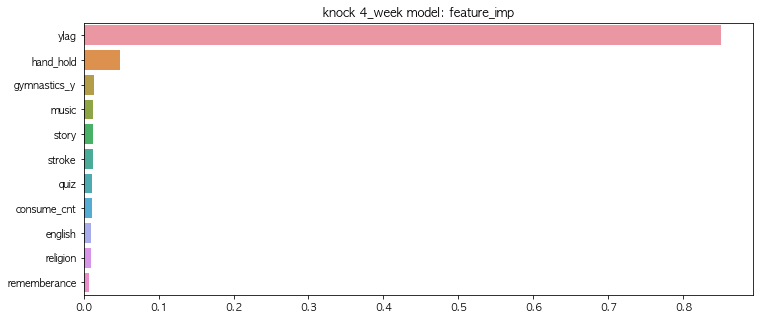

knock : 1246명 : 44.15087519459514


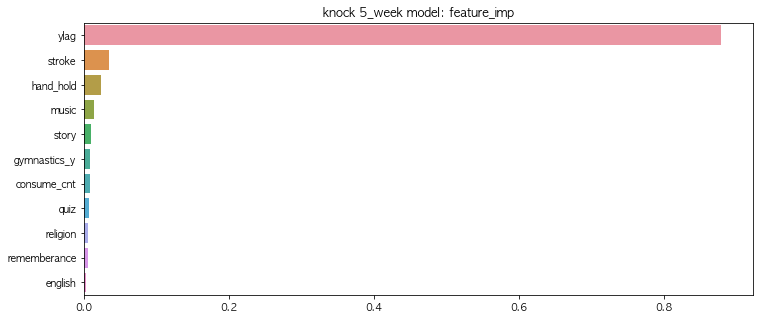

knock : 1210명 : 48.59619349462679


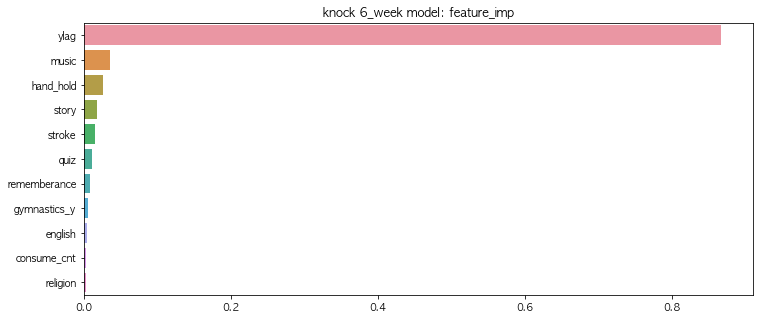

knock : 1152명 : 31.908191178233235


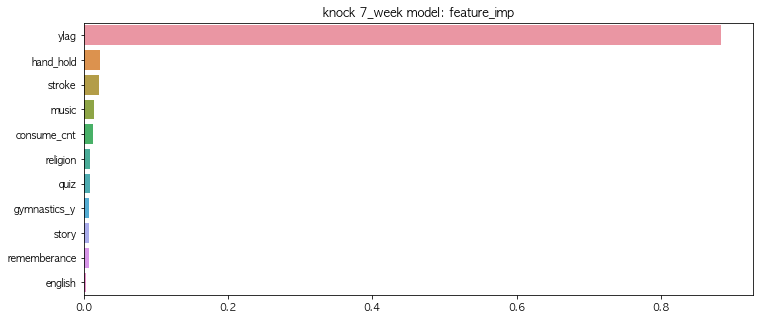

knock : 1106명 : 37.36949778836143


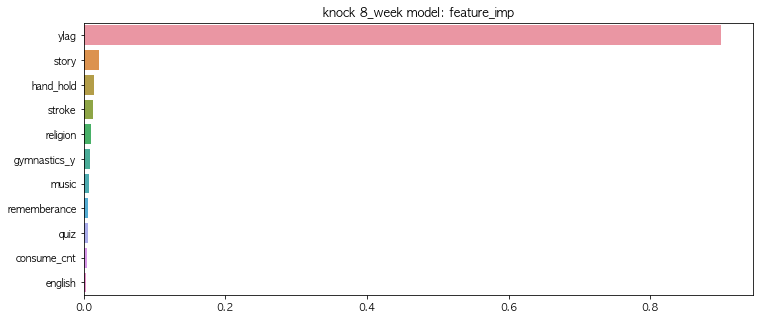

knock : 1038명 : 54.160041981017024


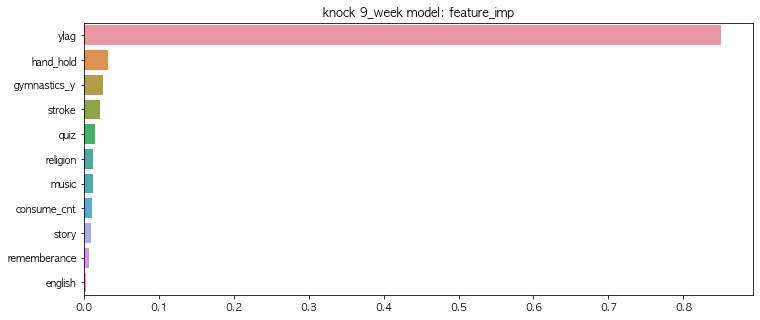

knock : 954명 : 53.04319365772569


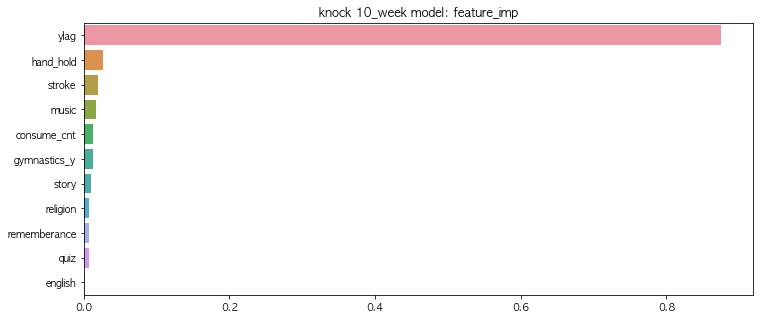

quiz : 1431명 : 2.641287345446596


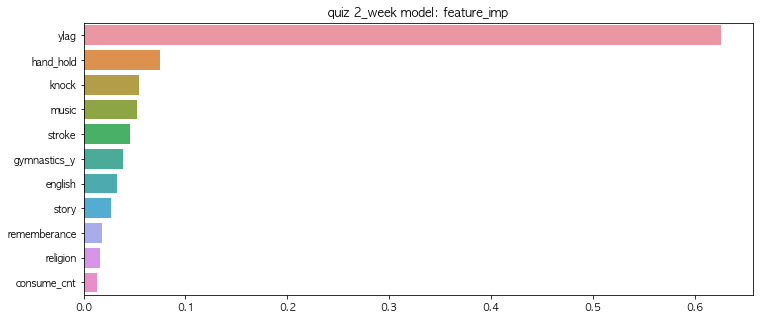

quiz : 1420명 : 1.742927583376975


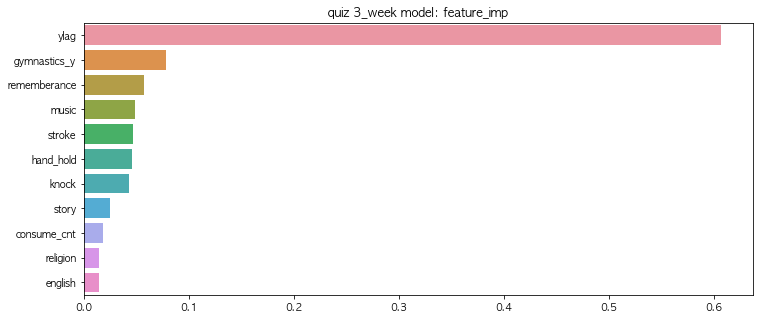

quiz : 1297명 : 1.6792117126918873


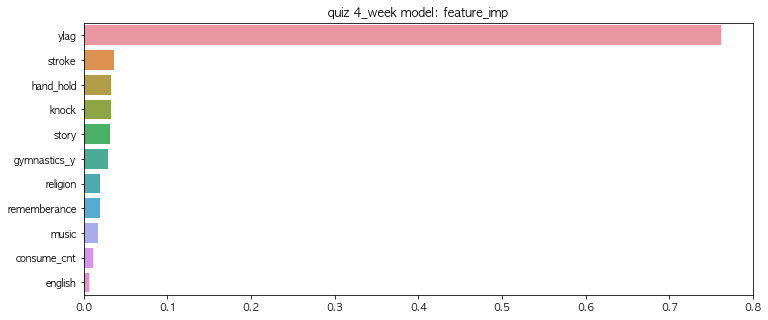

quiz : 1246명 : 1.5365693774179685


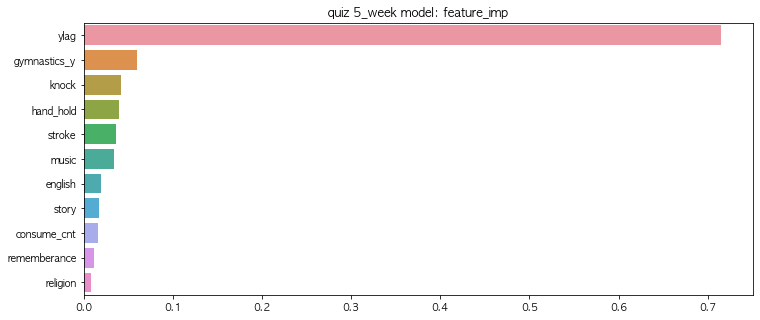

quiz : 1210명 : 1.2284330984733012


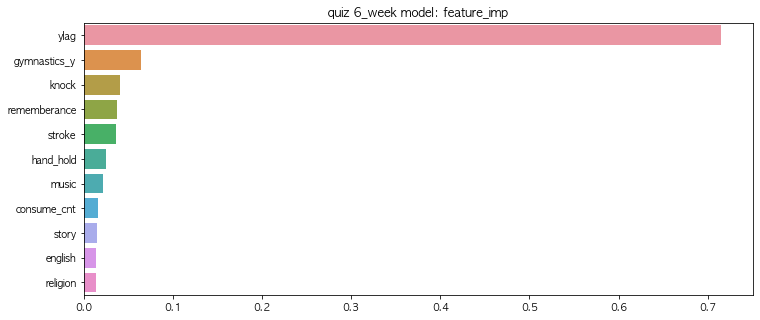

quiz : 1152명 : 1.235798126563807


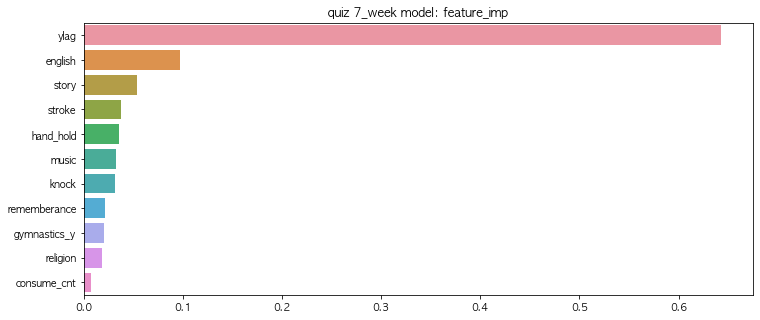

quiz : 1106명 : 1.5010652081543434


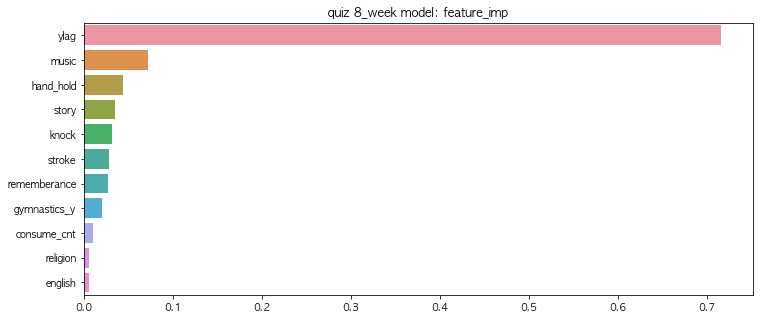

quiz : 1038명 : 1.0978121032622705


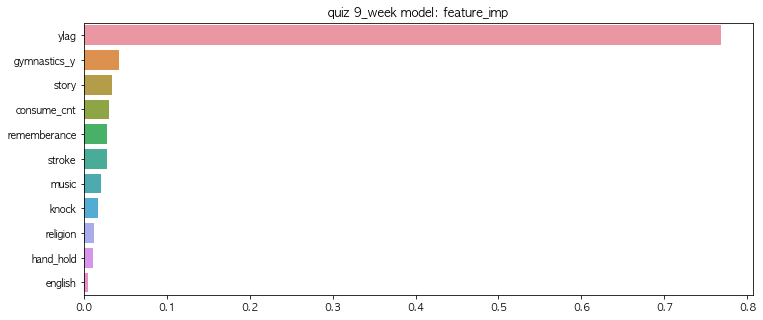

quiz : 954명 : 0.9240620088266002


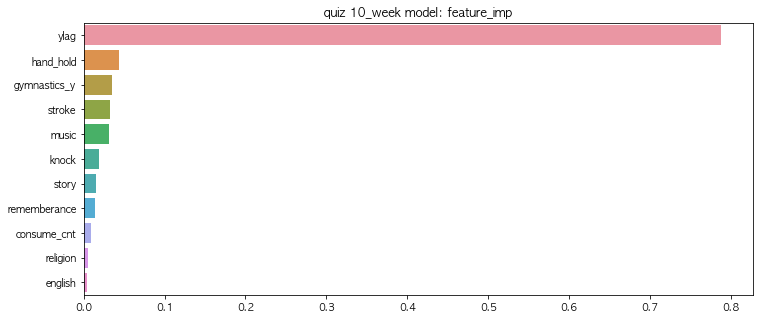

music : 1431명 : 9.624513458356414


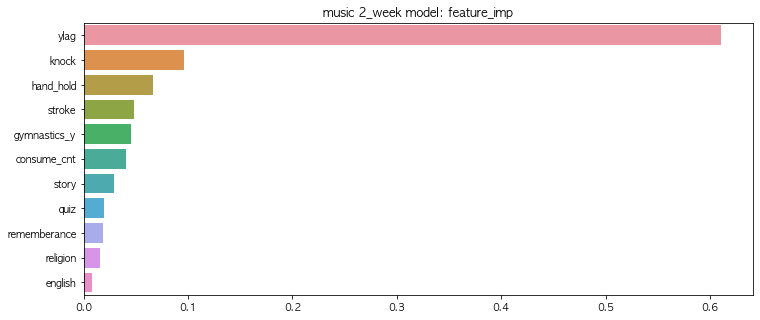

music : 1420명 : 5.103924850092716


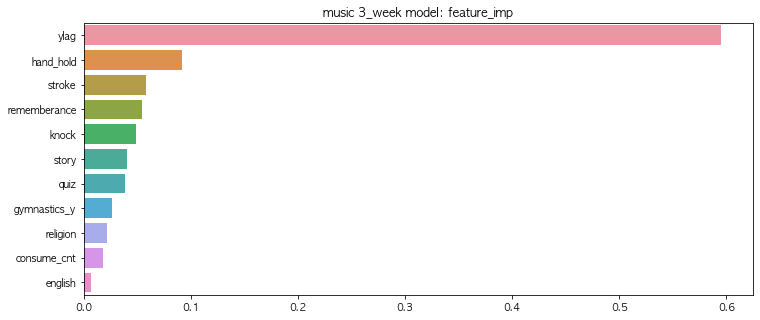

music : 1297명 : 6.026430898316762


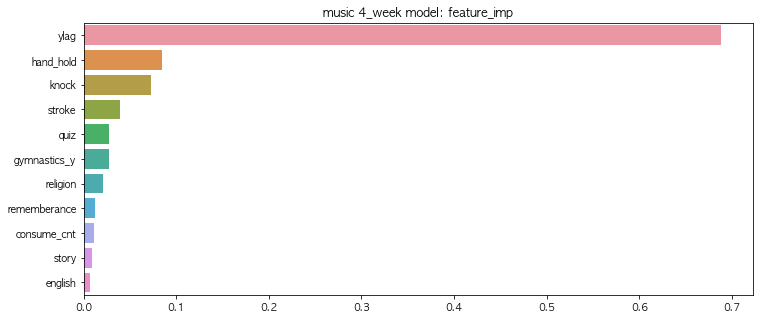

music : 1246명 : 4.570015472540468


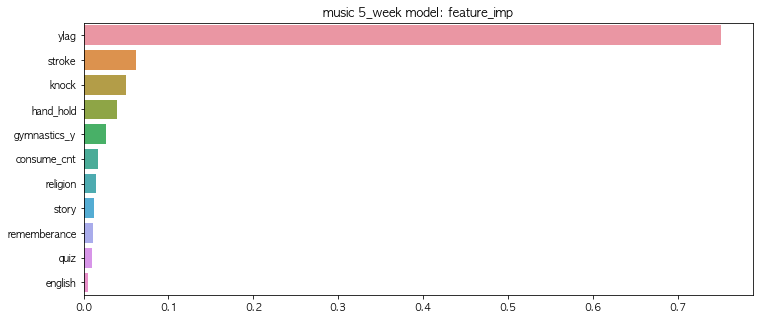

music : 1210명 : 5.895960647682655


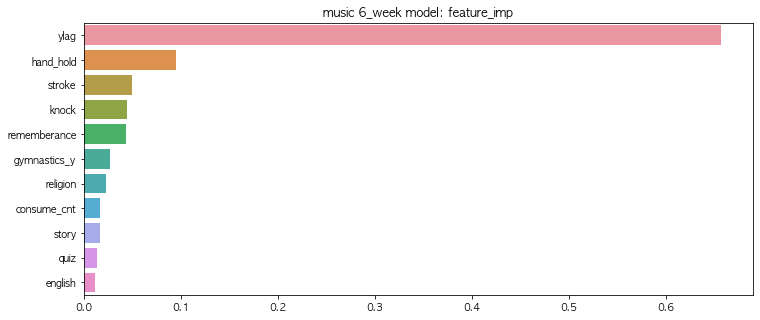

music : 1152명 : 2.374983050768649


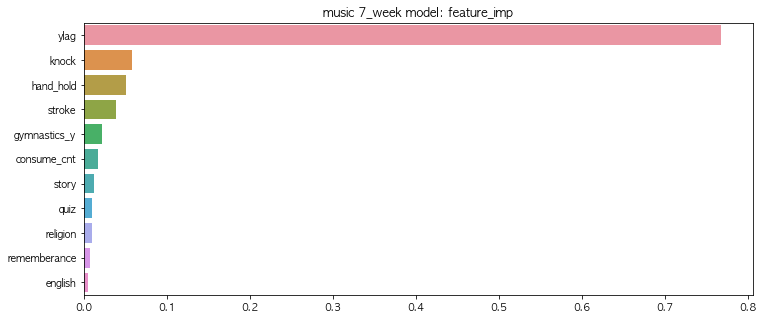

music : 1106명 : 3.195043616496709


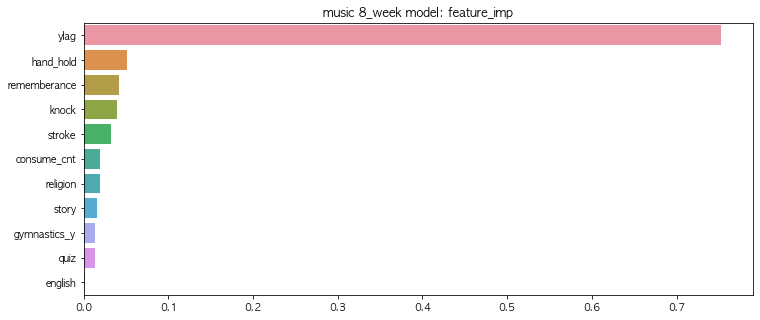

music : 1038명 : 2.5528030106313944


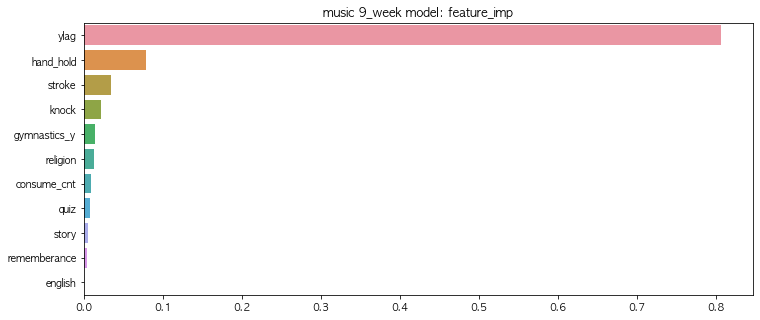

music : 954명 : 2.823961877174095


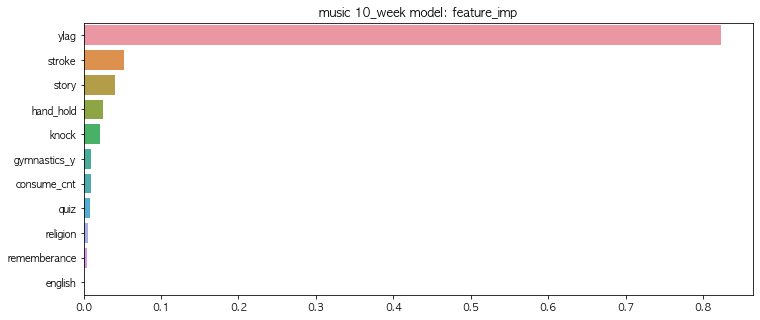

gymnastics_y : 1431명 : 3.403404257378054


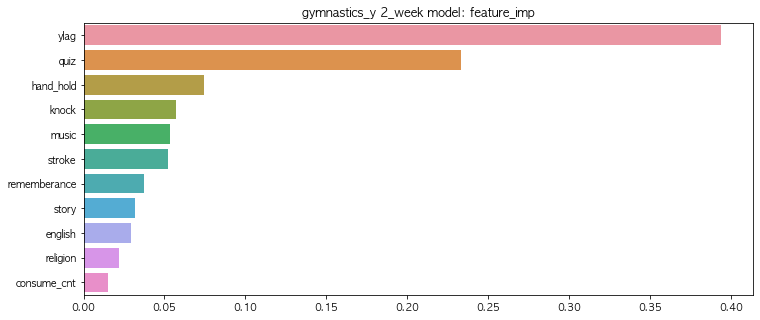

gymnastics_y : 1420명 : 1.9898368007184115


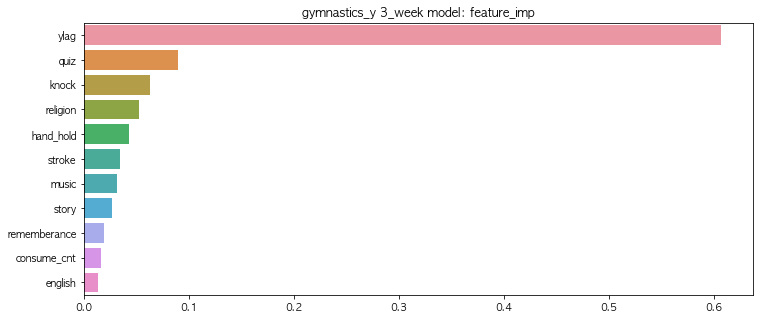

gymnastics_y : 1297명 : 2.1340043869443175


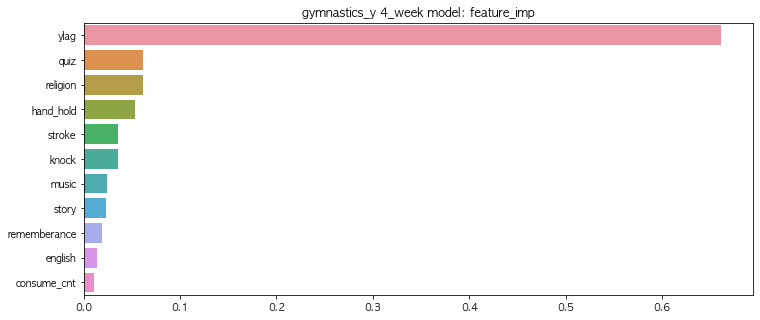

gymnastics_y : 1246명 : 1.7540136179940935


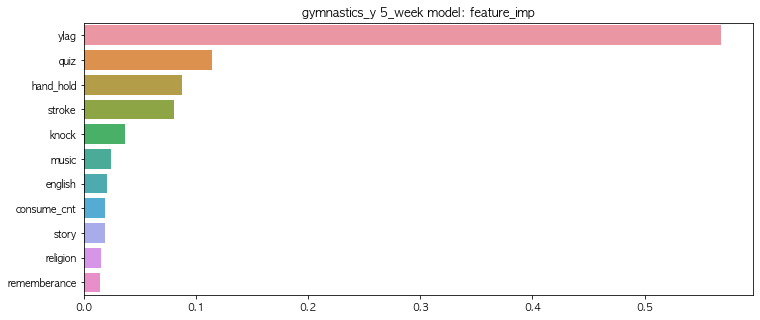

gymnastics_y : 1210명 : 1.4516801373133972


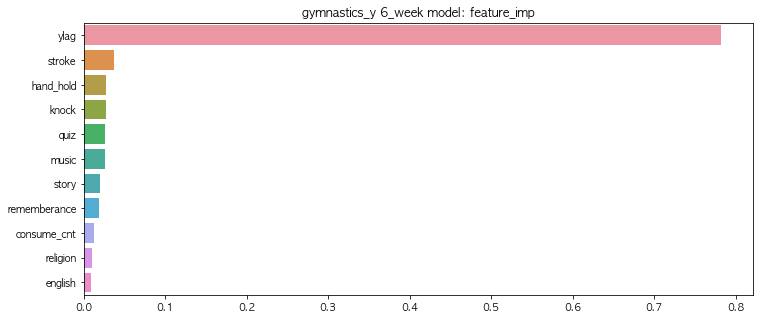

gymnastics_y : 1152명 : 1.340696286339208


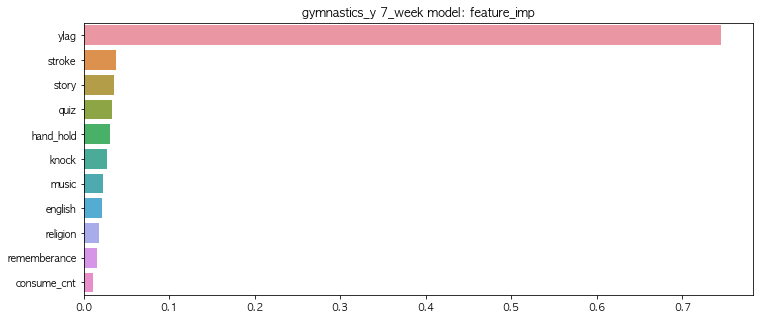

gymnastics_y : 1106명 : 1.3801788391800554


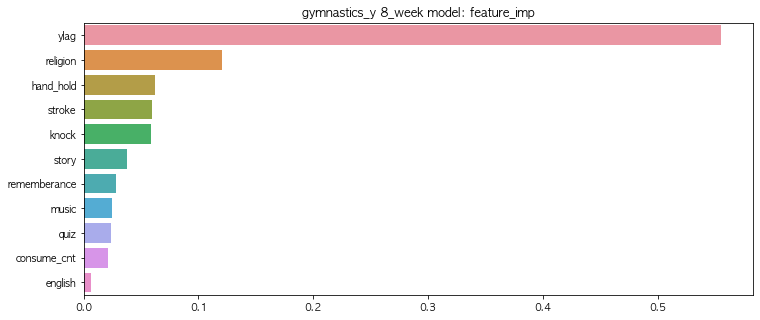

gymnastics_y : 1038명 : 1.423587434879511


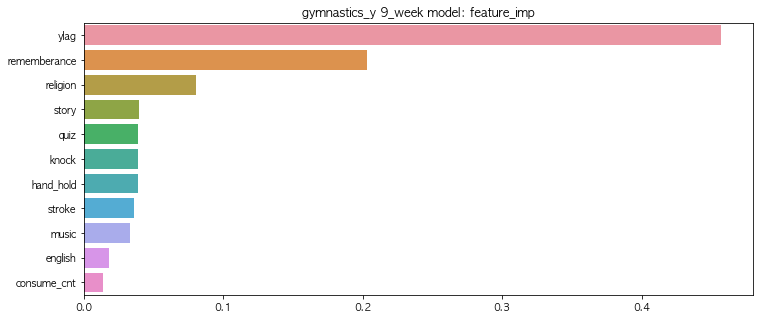

gymnastics_y : 954명 : 1.3637317191094491


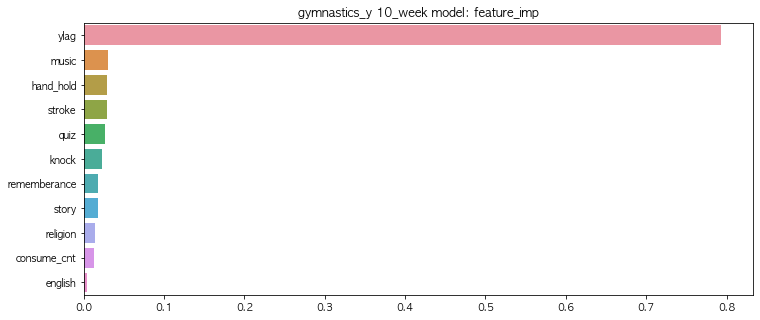

In [32]:
for pcol in predict_col:    
    for num in range(1,10): 
        
        y = df_reg[df_reg.use_week == num+1][pcol].sort_index()
        X = df_reg[(df_reg.use_week == num) &(df_reg.doll_id.isin(y.index))]
        X = X.drop(['doll_id', 'use_week'], axis=1).sort_index()
        X = X.rename(columns = {pcol: 'ylag'})

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021,shuffle = True)

        model = RandomForestRegressor(random_state= 2021)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        run_error = mae(y_test, y_pred)
        res.loc[(res.index==pcol), num+1] = run_error

        print(pcol, f'{len(X)}명', run_error, sep = ' : ')

        ft_importances = pd.Series(model.feature_importances_, index = X_train.columns)
        ft_importances = ft_importances.sort_values(ascending=False)

        plt.figure(figsize=(12, 5))
        plt.title(f"{pcol} {num+1}_week model: feature_imp")
        sns.barplot(x=ft_importances, y = ft_importances.index)
        plt.show()

In [33]:
res

,2,3,4,5,6,7,8,9,10
stroke,53.8027,35.1510,24.1996,28.6823,31.4870,18.5069,18.6719,16.1945,14.1407
hand_hold,88.4625,49.9199,53.3108,34.6231,41.3097,27.9836,25.4731,21.9437,31.1946
knock,60.6780,46.7193,42.4346,44.1509,48.5962,31.9082,37.3695,54.1600,53.0432
quiz,2.6413,1.7429,1.6792,1.5366,1.2284,1.2358,1.5011,1.0978,0.9241
music,9.6245,5.1039,6.0264,4.5700,5.8960,2.3750,3.1950,2.5528,2.8240
gymnastics_y,3.4034,1.9898,2.1340,1.7540,1.4517,1.3407,1.3802,1.4236,1.3637


In [34]:
res_h = pd.DataFrame(index = predict_col, columns = [2,3,4,5,6,7,8,9,10])

res_h

,2,3,4,5,6,7,8,9,10
stroke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hand_hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
knock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quiz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gymnastics_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def corr_check_plot(dat): 
    X_cor = deepcopy(dat)
    plt.subplots(figsize=(10,10))
    sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

In [36]:
from sklearn.preprocessing import MinMaxScaler

stroke : 1431명 : 37.172413751663555


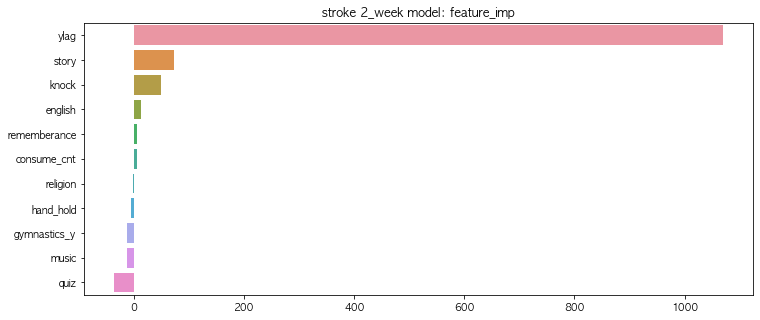

stroke : 1420명 : 29.06020182070018


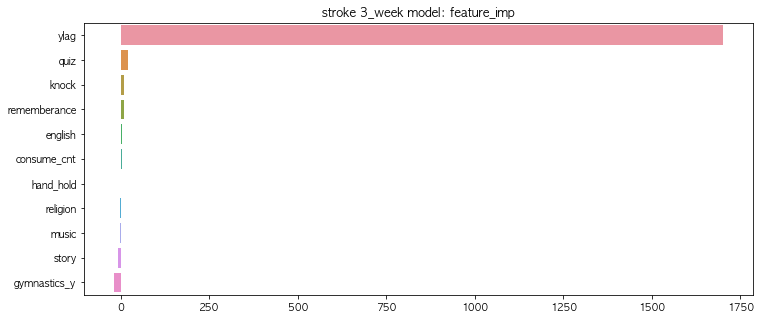

stroke : 1297명 : 19.23097072135277


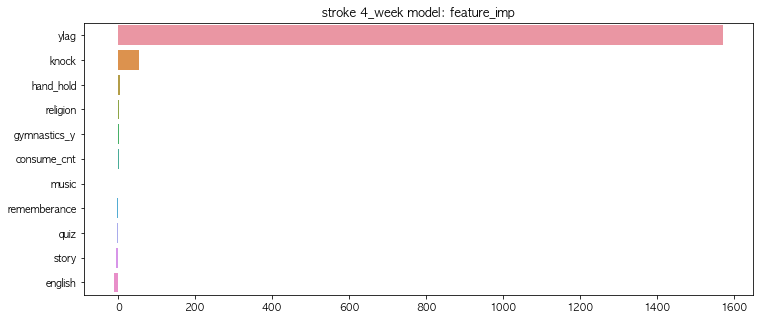

stroke : 1246명 : 19.13791504923253


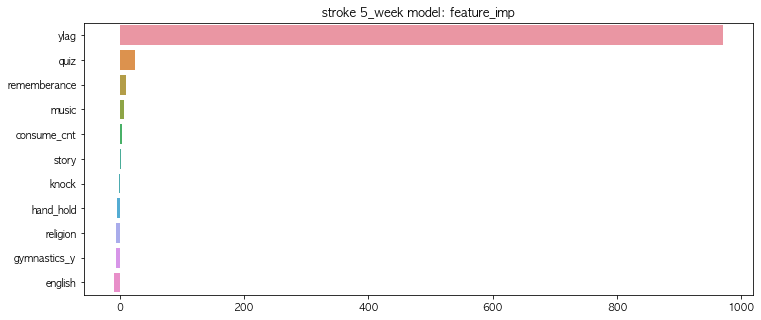

stroke : 1210명 : 26.802265767771818


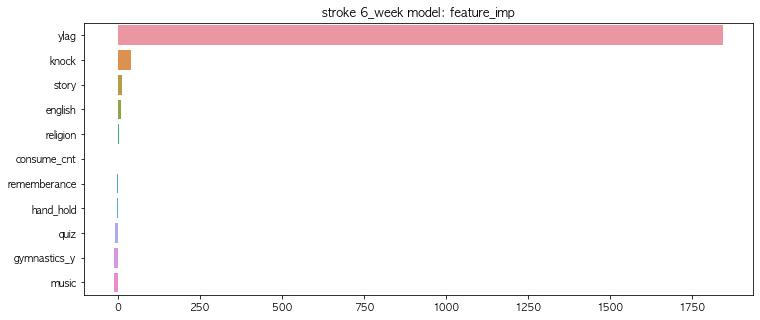

stroke : 1152명 : 16.03295824144756


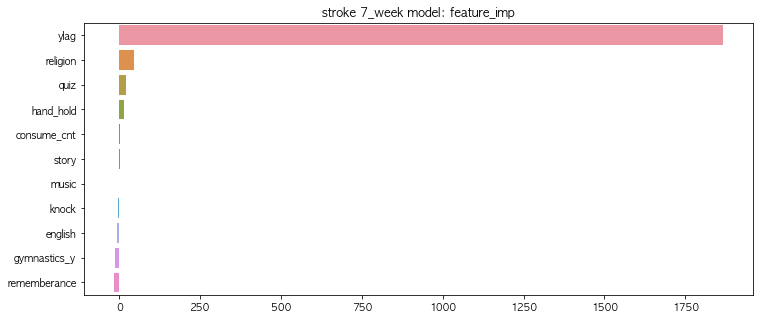

stroke : 1106명 : 18.28958359706385


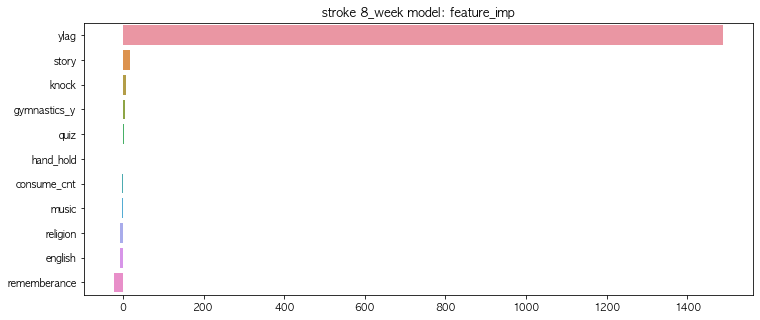

stroke : 1038명 : 12.434589359540418


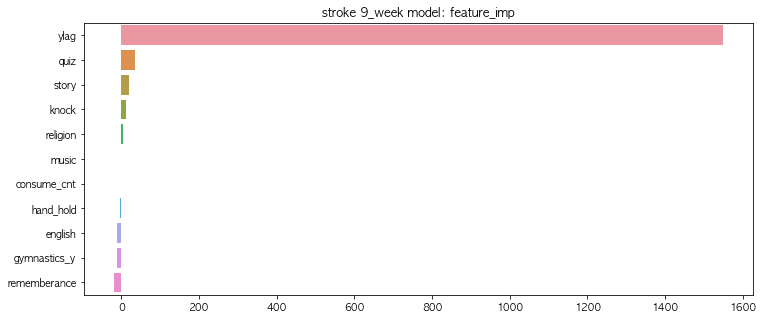

stroke : 954명 : 13.15256157871219


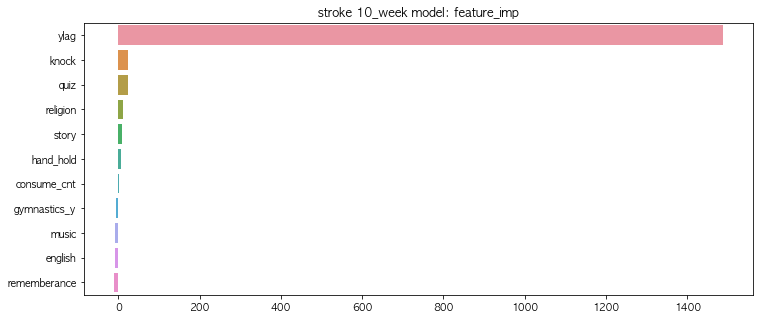

hand_hold : 1431명 : 66.36004661066336


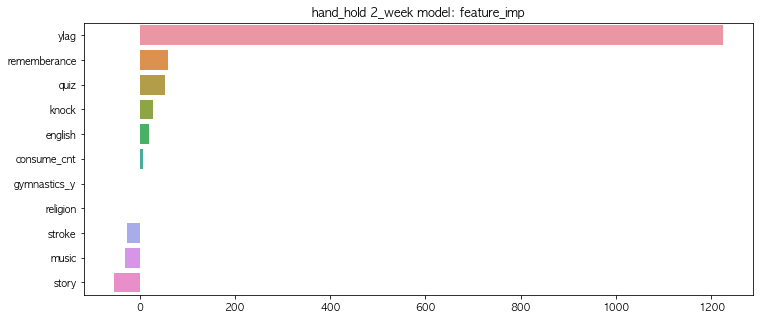

hand_hold : 1420명 : 39.245921645218814


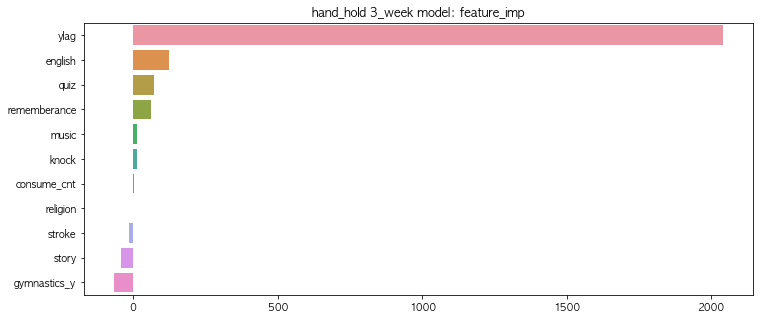

hand_hold : 1297명 : 46.66822986950973


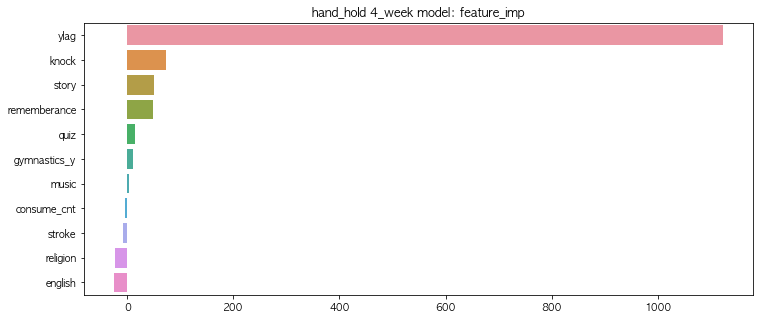

hand_hold : 1246명 : 30.249232033440038


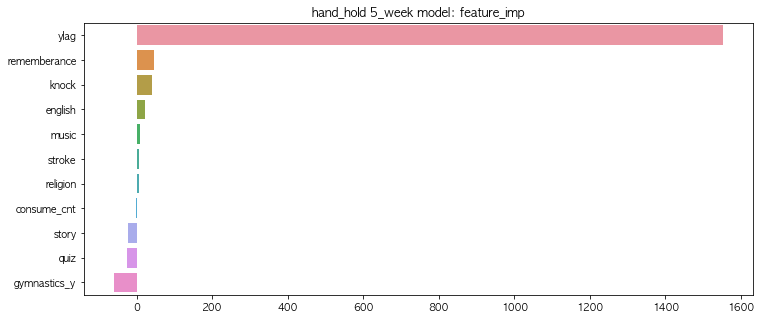

hand_hold : 1210명 : 31.693249452629676


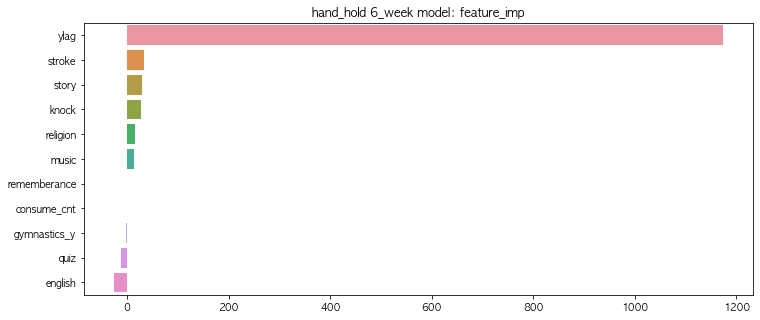

hand_hold : 1152명 : 23.811387305017615


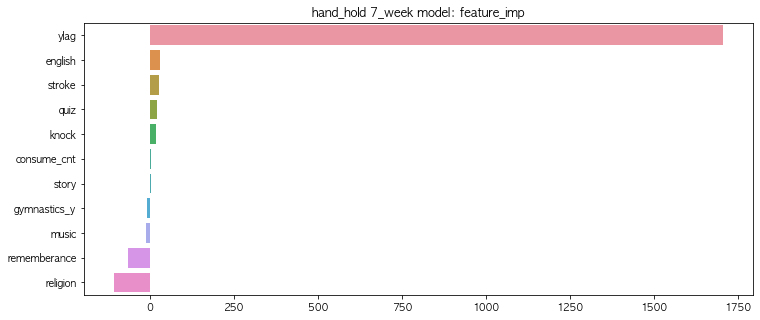

hand_hold : 1106명 : 21.581154365932175


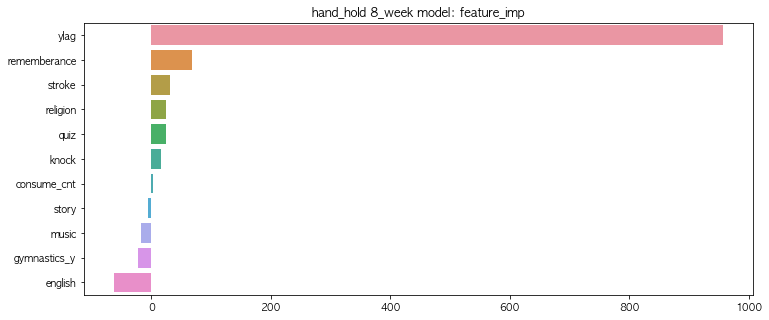

hand_hold : 1038명 : 19.801057953971206


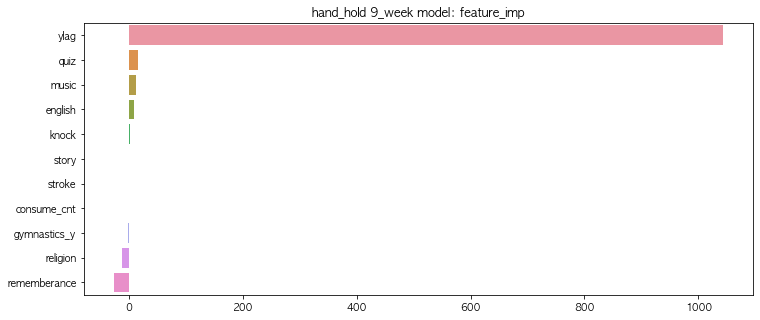

hand_hold : 954명 : 23.174211134363976


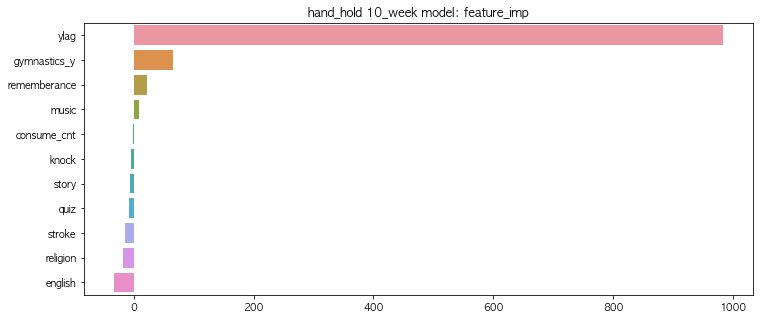

knock : 1431명 : 43.93557134718749


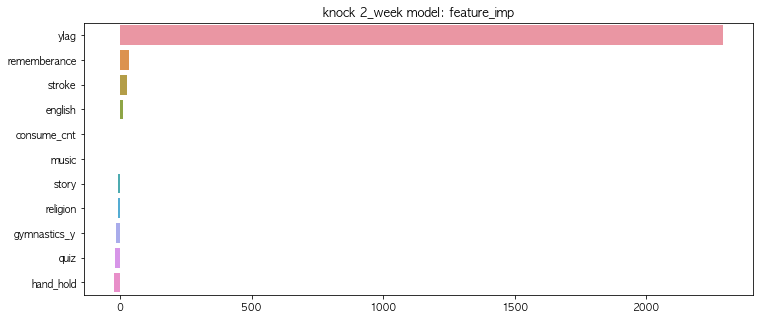

knock : 1420명 : 36.0795176094707


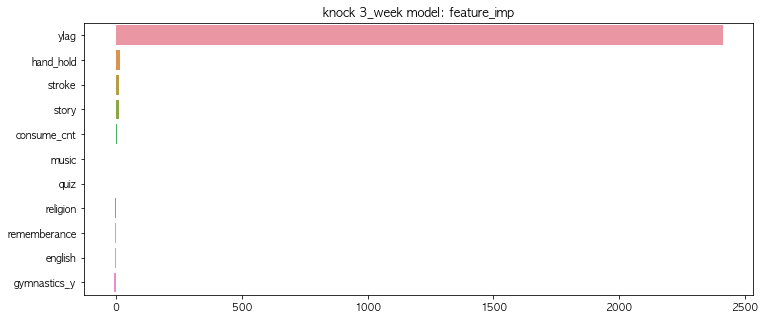

knock : 1297명 : 35.28047632804174


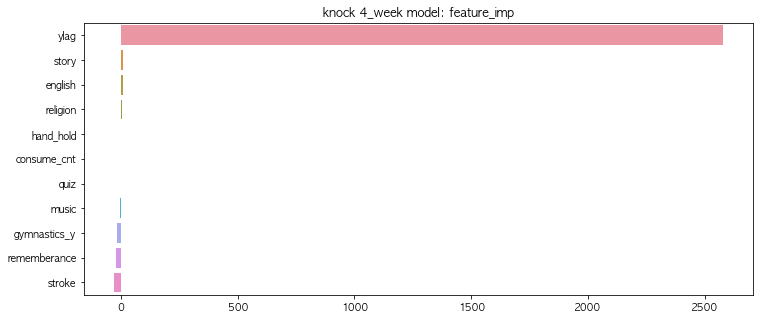

knock : 1246명 : 39.07819545021271


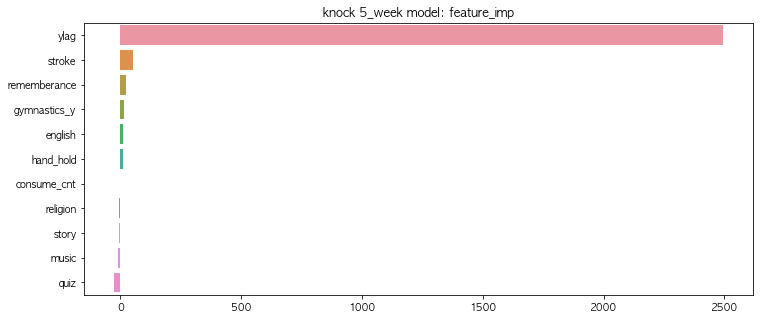

knock : 1210명 : 41.110635073821285


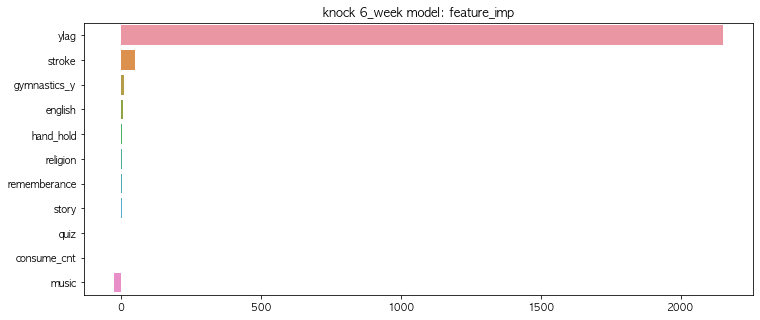

knock : 1152명 : 24.99383706733385


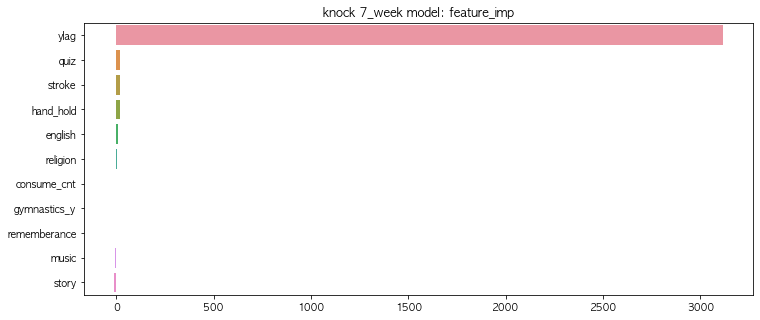

knock : 1106명 : 33.487832171890304


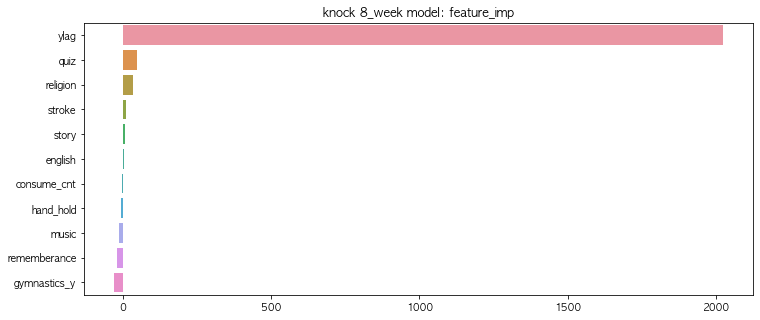

knock : 1038명 : 38.14472498106928


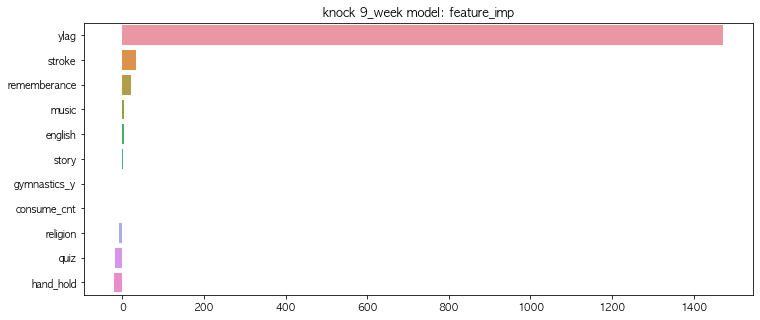

knock : 954명 : 44.7953015126616


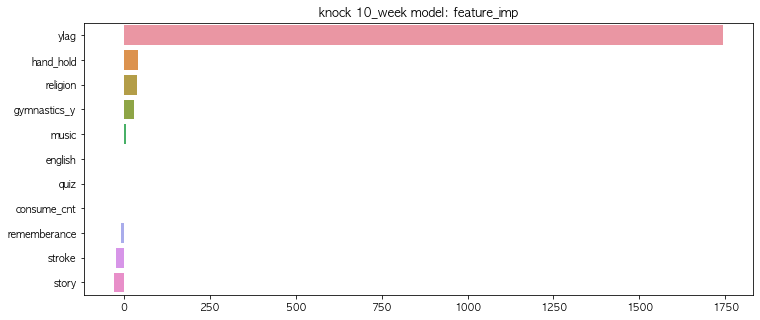

quiz : 1431명 : 2.1808078655866603


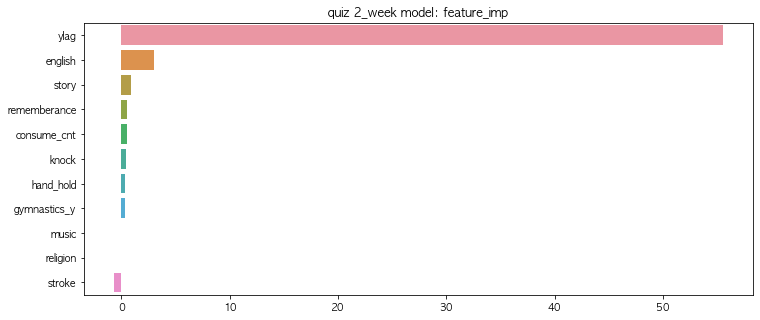

quiz : 1420명 : 1.2993941558804376


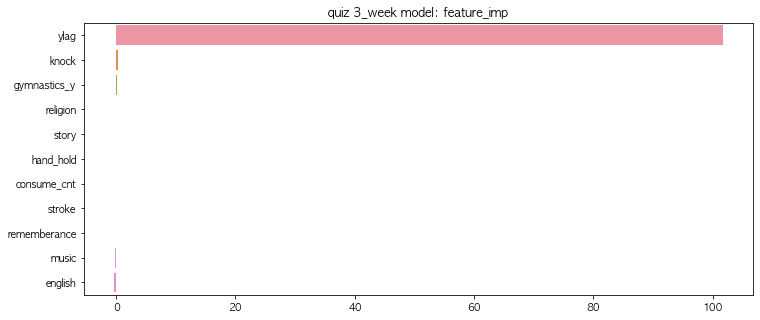

quiz : 1297명 : 1.3285683379451427


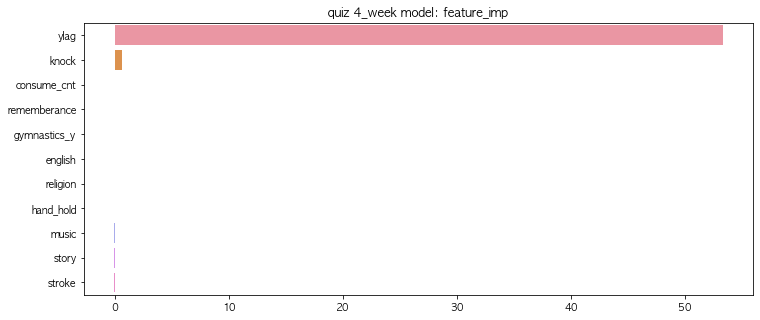

quiz : 1246명 : 1.0675830995294104


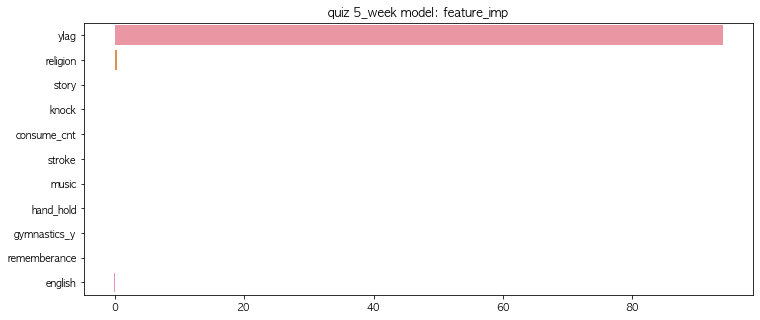

quiz : 1210명 : 0.9207859766423687


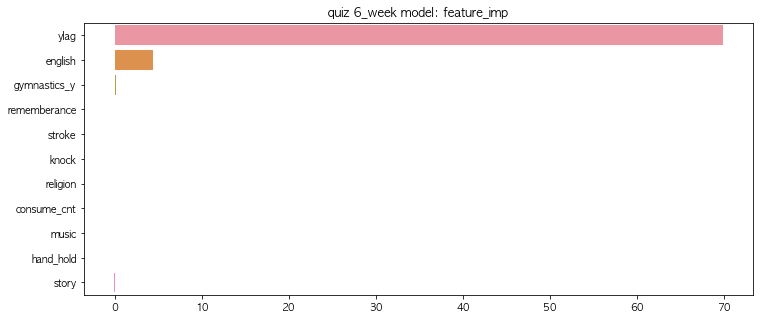

quiz : 1152명 : 0.9782746654014347


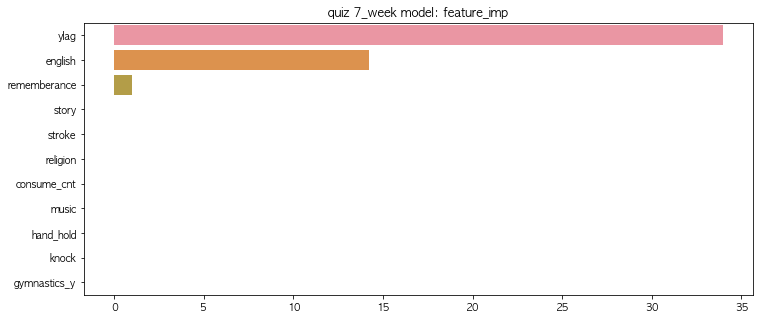

quiz : 1106명 : 1.3706487806894243


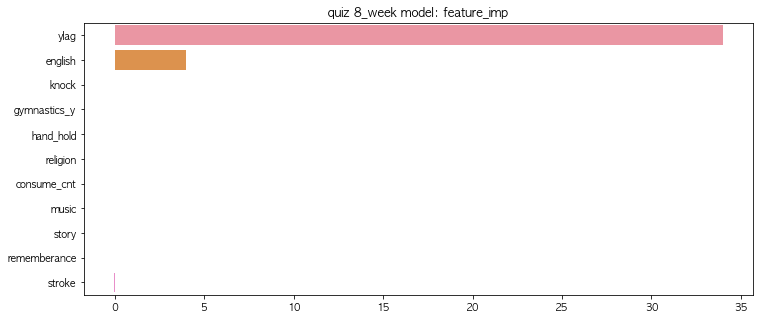

quiz : 1038명 : 0.8594611995540096


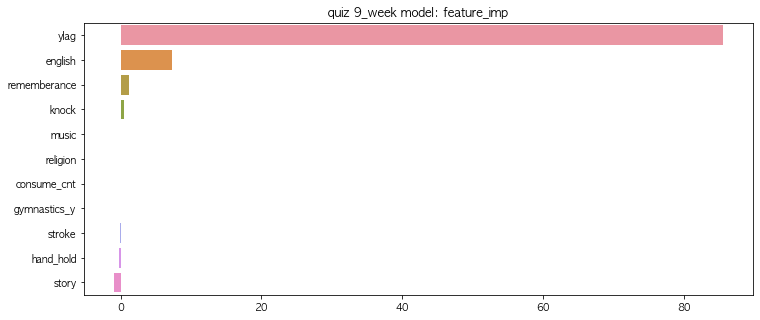

quiz : 954명 : 0.7291791148369439


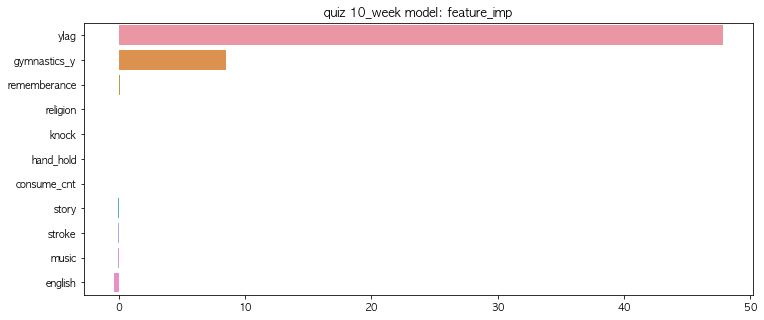

music : 1431명 : 6.794325197805756


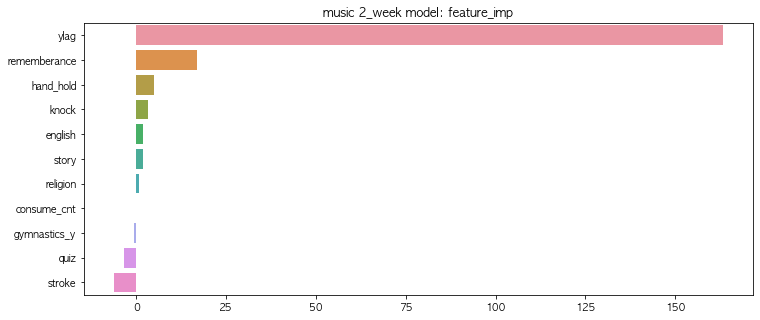

music : 1420명 : 4.444255942463155


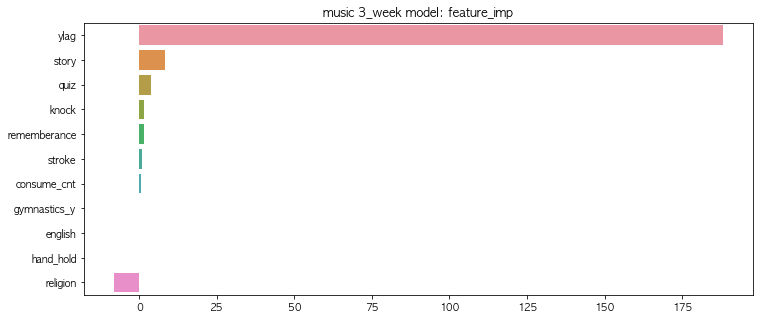

music : 1297명 : 5.231340586376924


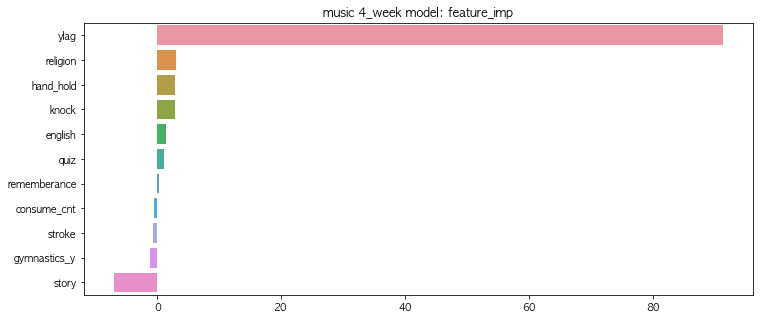

music : 1246명 : 4.012274294491305


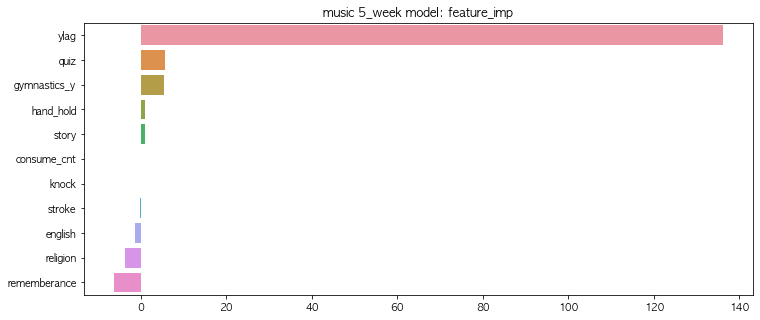

music : 1210명 : 4.449301153881546


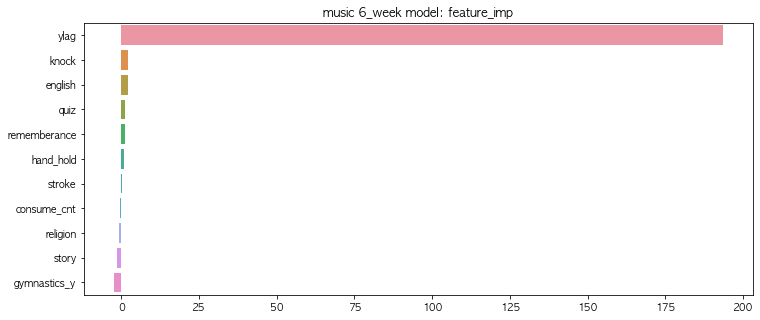

music : 1152명 : 1.8992602435949872


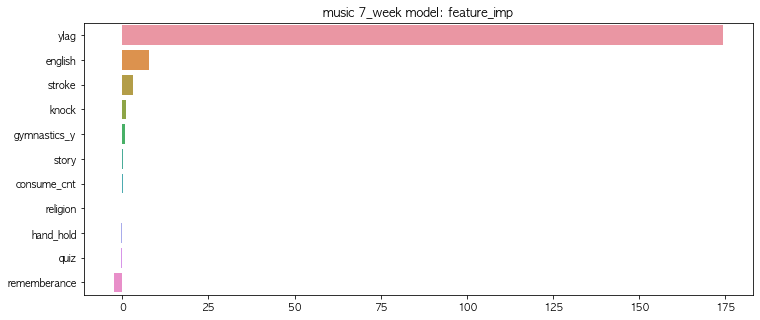

music : 1106명 : 2.422379607049569


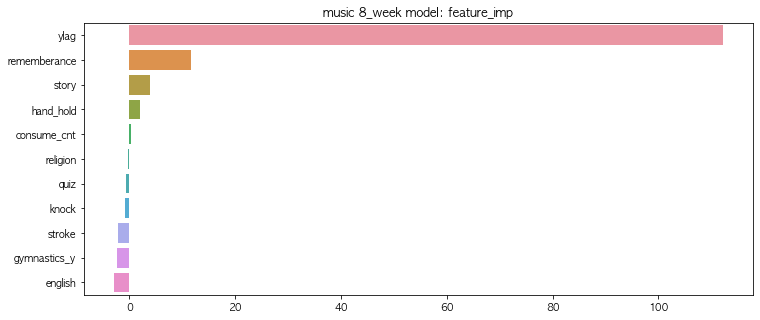

music : 1038명 : 1.9175745743928658


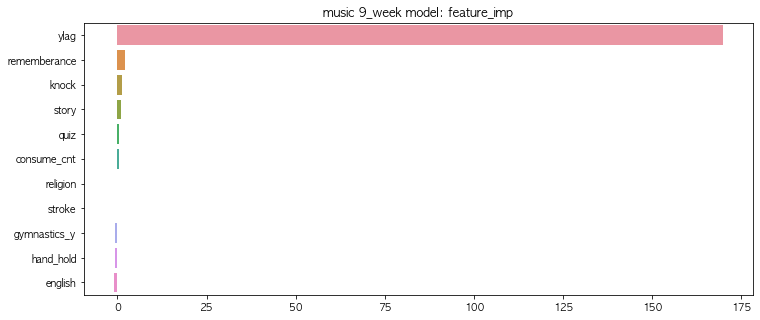

music : 954명 : 2.1089755791267786


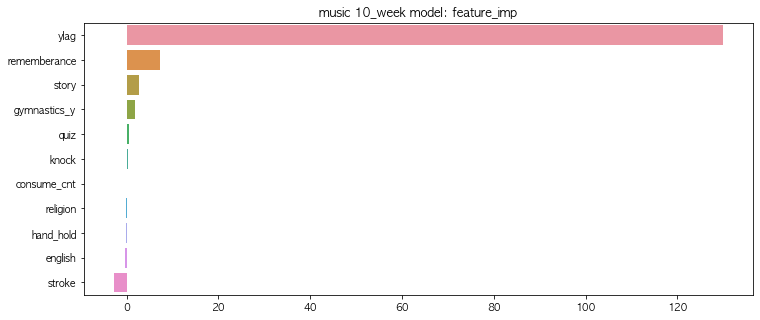

gymnastics_y : 1431명 : 2.5379295409850924


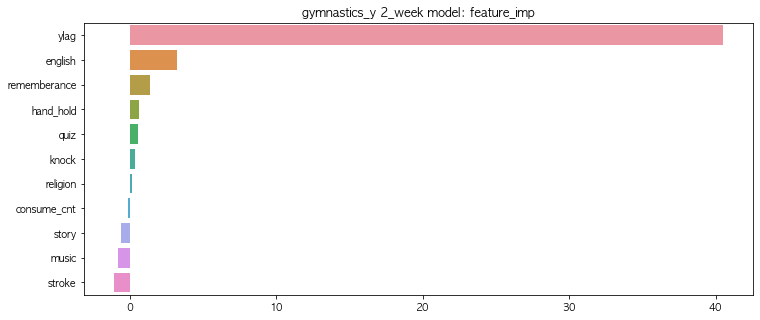

gymnastics_y : 1420명 : 1.5661133063395953


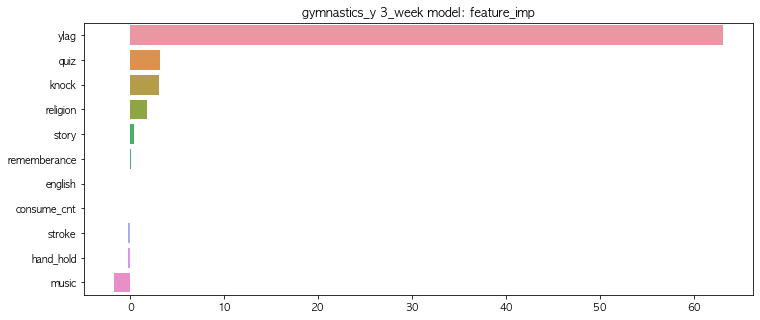

gymnastics_y : 1297명 : 1.718150974452182


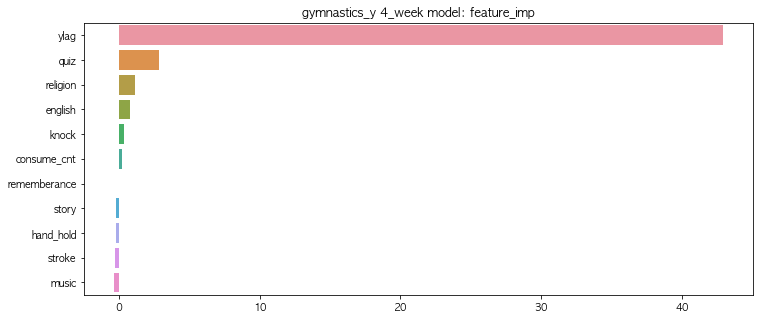

gymnastics_y : 1246명 : 1.3548415331033334


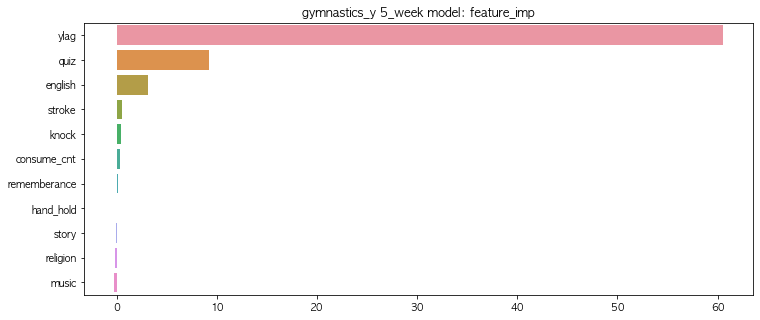

gymnastics_y : 1210명 : 1.2608493443803088


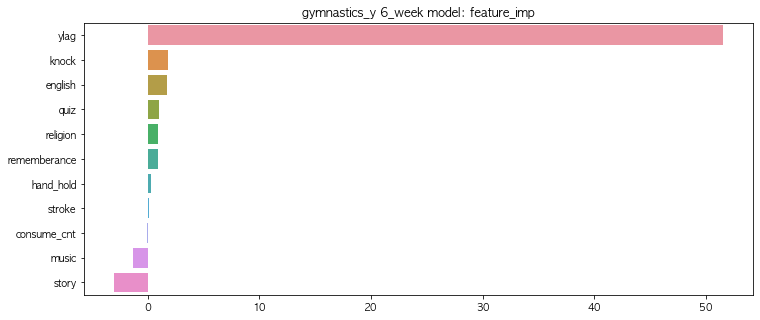

gymnastics_y : 1152명 : 1.0672302186592637


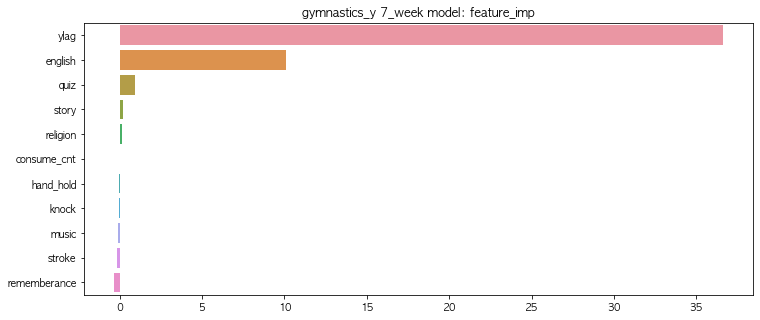

gymnastics_y : 1106명 : 1.091156185639397


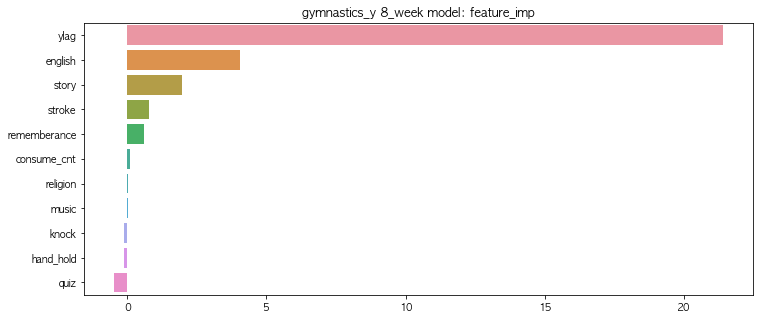

gymnastics_y : 1038명 : 1.029290071730166


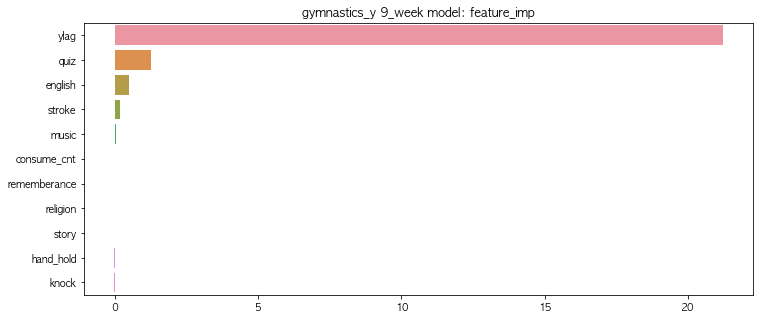

gymnastics_y : 954명 : 1.1406172135727246


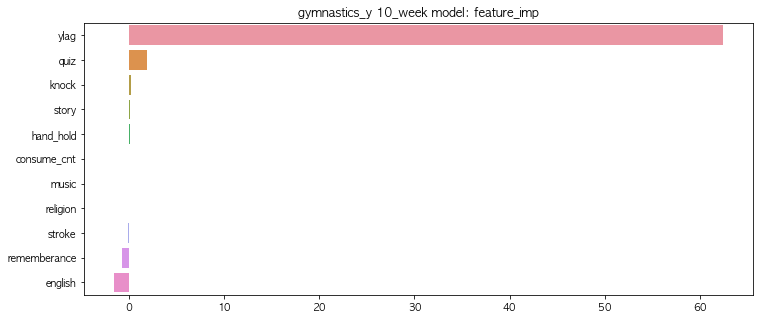

In [37]:
for pcol in predict_col:    
    for num in range(1,10): 
        
        y = df_reg[df_reg.use_week == num+1][pcol].sort_index()
        X = df_reg[(df_reg.use_week == num) &(df_reg.doll_id.isin(y.index))]
        X = X.drop(['doll_id', 'use_week'], axis=1).sort_index()
        X = X.rename(columns = {pcol: 'ylag'})
        scaler = MinMaxScaler()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                            random_state=2021, shuffle = True)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model = HuberRegressor()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        run_error = mae(y_test, y_pred)
        res_h.loc[(res_h.index==pcol), num+1] = run_error

        print(pcol, f'{len(X)}명', run_error, sep = ' : ')

        ft_importances = pd.Series(model.coef_, index = X.columns)
        ft_importances = ft_importances.sort_values(ascending=False)

        plt.figure(figsize=(12, 5))
        plt.title(f"{pcol} {num+1}_week model: feature_imp")
        sns.barplot(x=ft_importances, y = ft_importances.index)
        plt.show()

In [38]:
res

,2,3,4,5,6,7,8,9,10
stroke,53.8027,35.1510,24.1996,28.6823,31.4870,18.5069,18.6719,16.1945,14.1407
hand_hold,88.4625,49.9199,53.3108,34.6231,41.3097,27.9836,25.4731,21.9437,31.1946
knock,60.6780,46.7193,42.4346,44.1509,48.5962,31.9082,37.3695,54.1600,53.0432
quiz,2.6413,1.7429,1.6792,1.5366,1.2284,1.2358,1.5011,1.0978,0.9241
music,9.6245,5.1039,6.0264,4.5700,5.8960,2.3750,3.1950,2.5528,2.8240
gymnastics_y,3.4034,1.9898,2.1340,1.7540,1.4517,1.3407,1.3802,1.4236,1.3637


In [39]:
res_h

,2,3,4,5,6,7,8,9,10
stroke,37.1724,29.0602,19.2310,19.1379,26.8023,16.0330,18.2896,12.4346,13.1526
hand_hold,66.3600,39.2459,46.6682,30.2492,31.6932,23.8114,21.5812,19.8011,23.1742
knock,43.9356,36.0795,35.2805,39.0782,41.1106,24.9938,33.4878,38.1447,44.7953
quiz,2.1808,1.2994,1.3286,1.0676,0.9208,0.9783,1.3706,0.8595,0.7292
music,6.7943,4.4443,5.2313,4.0123,4.4493,1.8993,2.4224,1.9176,2.1090
gymnastics_y,2.5379,1.5661,1.7182,1.3548,1.2608,1.0672,1.0912,1.0293,1.1406


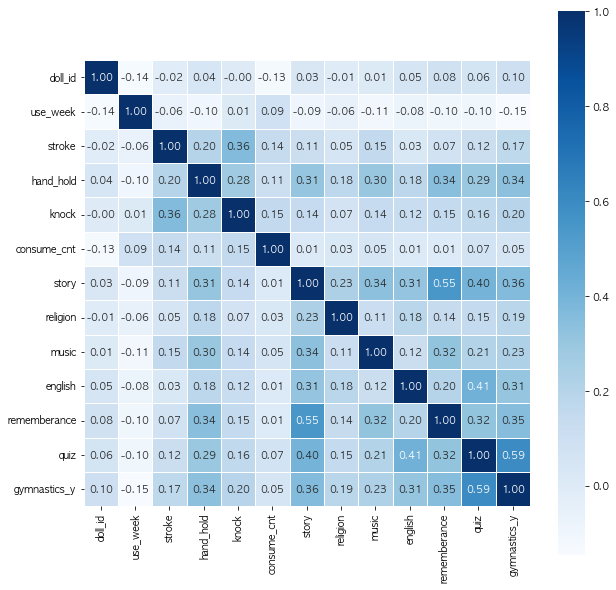

In [40]:
corr_check_plot(df_reg)

In [48]:
aa = pd.DataFrame(df_reg[predict_col].std())
aa.columns = ['std']
aa 

,std
stroke,138.6715
hand_hold,152.8391
knock,228.9916
quiz,6.3950
music,19.2449
gymnastics_y,6.0323


괜찮은 유저: 128182, 128130, 128319

In [194]:
user = 133003

In [195]:
user_df = df_reg[df_reg.index==user]

for pcol in predict_col: 
    user_df[f'{pcol}_predict'] = np.nan
    
dat = deepcopy(user_df)

In [196]:
for pcol in predict_col:    
    for num in range(1,10): 
        
        try: y = df_reg[df_reg.use_week == num+1][pcol].sort_index()
        except: continue
        X = df_reg[(df_reg.use_week == num) &(df_reg.doll_id.isin(y.index))]
        X = X.drop(['doll_id', 'use_week'], axis=1).sort_index()
        X = X.rename(columns = {pcol: 'ylag'})
        scaler = MinMaxScaler()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                            random_state=2021, shuffle = True)
        X_train = scaler.fit_transform(X_train)
        
        X_tst = dat[dat.use_week==num][Xcol]
        X_tst = X_tst.rename(columns = {pcol: 'ylag'})
        X_tst = scaler.transform(X_tst)
        y_tst = dat[dat.use_week==num+1][pcol].values[0]

        model = HuberRegressor()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_tst)
        dat.loc[(dat.use_week==num+1), f'{pcol}_predict'] = y_pred
        
        print( pcol , num+1, '주차', " : ", np.abs(y_tst-y_pred))

stroke 2 주차  :  [25.51678954]
stroke 3 주차  :  [19.14426151]
stroke 4 주차  :  [3.3809692]
stroke 5 주차  :  [7.68293706]
stroke 6 주차  :  [2.02243575]
stroke 7 주차  :  [3.37532228]
stroke 8 주차  :  [2.98628102]
stroke 9 주차  :  [8.81213079]
stroke 10 주차  :  [1.05312308]
hand_hold 2 주차  :  [46.55345967]
hand_hold 3 주차  :  [14.22402048]
hand_hold 4 주차  :  [42.94993703]
hand_hold 5 주차  :  [2.07946737]
hand_hold 6 주차  :  [3.16366011]
hand_hold 7 주차  :  [4.80706209]
hand_hold 8 주차  :  [8.71887785]
hand_hold 9 주차  :  [0.96605901]
hand_hold 10 주차  :  [0.23341868]
knock 2 주차  :  [43.83424891]
knock 3 주차  :  [20.67685411]
knock 4 주차  :  [35.8477385]
knock 5 주차  :  [22.70261937]
knock 6 주차  :  [14.96870416]
knock 7 주차  :  [0.56266706]
knock 8 주차  :  [26.37973541]
knock 9 주차  :  [24.25805091]
knock 10 주차  :  [20.37702973]
quiz 2 주차  :  [1.95502879]
quiz 3 주차  :  [0.04943375]
quiz 4 주차  :  [0.24624061]
quiz 5 주차  :  [0.7771033]
quiz 6 주차  :  [0.000715]
quiz 7 주차  :  [0.00012366]
quiz 8 주차  :  [0.08296117]

In [197]:
dat

,doll_id,use_week,stroke,hand_hold,knock,consume_cnt,story,religion,music,english,rememberance,quiz,gymnastics_y,stroke_predict,hand_hold_predict,knock_predict,quiz_predict,music_predict,gymnastics_y_predict
doll_id,,,,,,,,,,,,,,,,,,,
133003,133003,1.0000,19.0000,105.0000,161.0000,0.0000,1.0000,0.0000,7.0000,1.0000,1.0000,2.0000,3.0000,NaN,NaN,NaN,NaN,NaN,NaN
133003,133003,2.0000,41.0000,109.0000,186.0000,0.0000,1.0000,0.0000,14.0000,0.0000,1.0000,3.0000,2.0000,15.4832,62.4465,142.1658,1.0450,3.6397,1.3662
133003,133003,3.0000,11.0000,54.0000,158.0000,0.0000,2.0000,0.0000,9.0000,1.0000,1.0000,2.0000,1.0000,30.1443,68.2240,137.3231,2.0494,7.1893,1.2325
133003,133003,4.0000,15.0000,3.0000,114.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,11.6190,45.9499,149.8477,1.2462,5.8394,0.7401
133003,133003,5.0000,21.0000,2.0000,118.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,13.3171,4.0795,95.2974,0.7771,0.8449,0.0890
133003,133003,6.0000,18.0000,6.0000,116.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,20.0224,2.8363,101.0313,0.0007,0.8989,0.0752
133003,133003,7.0000,10.0000,11.0000,98.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,13.3753,6.1929,97.4373,-0.0001,0.7593,0.0014
133003,133003,8.0000,6.0000,0.0000,61.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,8.9863,8.7189,87.3797,0.0830,1.2355,0.0856
133003,133003,9.0000,15.0000,1.0000,79.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.1879,0.0339,54.7419,0.0125,0.7417,-0.0005


In [198]:
# df_filter[df_filter.doll_id.isin(use_id2)].head(30)

In [199]:
tmp = deepcopy(dat)
tmp = tmp.reset_index(drop=True)
pcol = 'stroke'

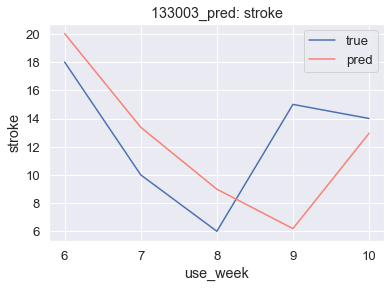

In [210]:
fig,ax = plt.subplots(1,1,figsize=(6, 4))
sns.set(font_scale=1.2)
sns.lineplot(x = tmp.use_week, y = tmp[pcol].tail(5), data = tmp, label= 'true')
sns.lineplot(x = tmp.use_week, y = tmp[f'{pcol}_predict'].tail(5), color = 'salmon', label= 'pred')
plt.title(f'{user}_pred: {pcol}')
plt.show()

In [201]:
tmp = deepcopy(dat)
tmp = tmp.reset_index(drop=True)
pcol = 'stroke'

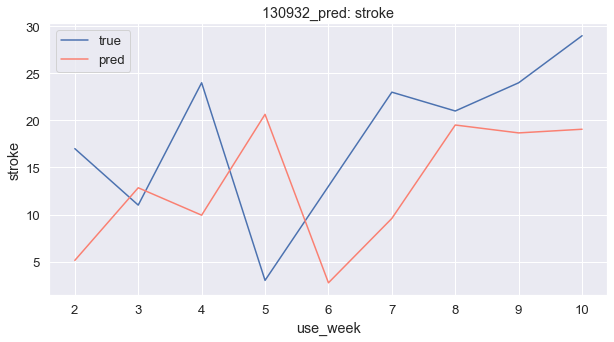

In [151]:
fig,ax = plt.subplots(1,1,figsize=(10, 5))
sns.set(font_scale=1.2)
sns.lineplot(x = tmp.use_week, y = tmp[pcol].tail(9), data = tmp, label= 'true')
sns.lineplot(x = tmp.use_week, y = tmp[f'{pcol}_predict'], color = 'salmon', label = 'pred')
plt.title(f'{user}_pred: {pcol}')
plt.show()

In [152]:
tmp = deepcopy(dat)
tmp = tmp.reset_index(drop=True)
pcol = 'hand_hold'

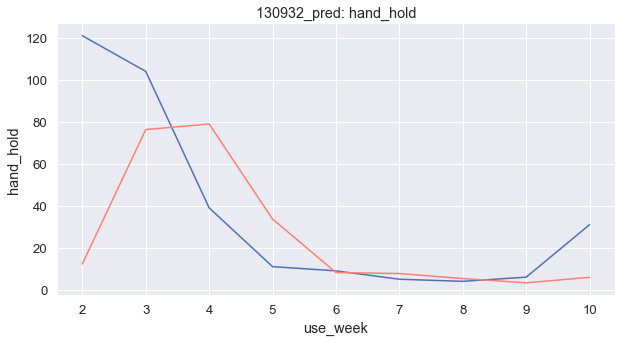

In [153]:
fig,ax = plt.subplots(1,1,figsize=(10, 5))
sns.set(font_scale=1.2)
sns.lineplot(x = tmp.use_week, y = tmp[pcol].tail(9), data = tmp)
sns.lineplot(x = tmp.use_week, y = tmp[f'{pcol}_predict'], color = 'salmon')
plt.title(f'{user}_pred: {pcol}')
plt.show()